## HMC Analysis

In [1]:
import os
import sys
import time
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

sys.path.append('..')
sns.set_palette('bright')
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sns.set(context="notebook")
sns.set_palette('bright')
#%matplotlib inline
#plt.style.use("/Users/saforem2/.config/matplotlib/stylelib/molokai.mplstyle")

In [3]:
def filter_dict(d, cond, key=None):
    if key is not None:
        val = d[key]
        if isinstance(val, dict):
            return {
                k: v for k, v in val.items() if cond
            }
        raise ValueError('If passing a key, d[key] should be a dict.')
    return {
        k: v for k, v in d.items() if cond
    }

In [4]:
def _look(p, s, conds=None):
    print(f'Looking in {p}...')
    matches = [x for x in Path(p).rglob(f'*{s}*')]
    if conds is not None:
        if isinstance(conds, (list, tuple)):
            for cond in conds:
                matches = [x for x in matches if cond(x)]
        else:
            matches = [x for x in matches if cond(x)]

    return matches

In [5]:
def _get_l2hmc_dirs(paths):
    def _look(p, s, conds=None):
        print(f'Looking in {p}...')
        matches = [x for x in Path(p).rglob(f'*{s}*')]
        if conds is not None:
            if isinstance(conds, (list, tuple)):
                for cond in conds:
                    matches = [x for x in matches if cond(x)]
            else:
                matches = [x for x in matches if cond(x)]
                
        return matches
    
    dirs = []
    conds = (
        lambda x: 'GaugeModel_logs' in (str(x)),
        lambda x: 'HMC_' not in str(x),
        lambda x: Path(x).is_dir(),
    )
    if isinstance(paths, (list, tuple)):
        for path in paths:
            dirs += _look(path, 'L16_b', conds)
            
    else:
        dirs = _look(paths, 'L16_b', conds)
        
            #print(f'Looking in {path}...')
            #dirs += [
            #    x for x in path.rglob('*L16_b*') 
            #    if 'GaugeModel_logs' in str(x)
            #    and 'HMC_' not in str(x)
            #    and x.is_dir()
            #]
            
    
    return dirs

def _get_hmc_dirs(paths):
    dirs = []
    for path in list(paths):
        path = Path(path)
        print(f'Looking in {path}...')
        dirs += [
            x for x in path.rglob('*hmc_logs*') 
            if 'hmc' in str(x).lower()
            and '_b128' in str(x)
            #if 'GaugeModel_logs' in str(x)
            #and 'HMC_' not in str(x)
            and x.is_dir()
        ]
    
    return dirs

In [6]:
import utils.file_io as io
from utils.attr_dict import AttrDict

def load_from_dir(d):
    darr = [x for x in d.iterdir() if x.is_dir()]
    
    for rd in darr:
        dqf = sorted(rd.glob('*dq.z*'))[0]
        qf = sorted(rd.glob('*charges.z*'))[0]
        pf = sorted(rd.rglob('*run_params.z*'))[0]
        
        dq = io.loadz(dqf)
        q = io.loadz(qf)
        rp = io.loadz(pf)
    pass
        

def load_charge_data(dirs, hmc=False):
    q = {}
    dq = {}
    for d in dirs:
        print(f'Looking in dir: {d}...')
        contents = os.listdir(d)
        
        if hmc:
            run_dir = Path(os.path.join(d, 'inference_hmc'))
        else:
            run_dir = Path(os.path.join(d, 'inference'))
            
        if run_dir.is_dir():
            run_dirs = [x for x in run_dir.iterdir() if x.is_dir()]
            for rd in run_dirs:
                print(f'......looking in run_dir: {rd}...')
                dq_file = sorted(rd.rglob('dq.z'))
                q_file = sorted(rd.rglob('charges.z'))
                rp_file = sorted(rd.rglob('run_params.z'))
                num_runs = len(dq_file)
                if num_runs > 0:
                    #for dqif, dqsf, qf, rpf in zip(dqi_file, dqs_file, q_file, rp_file):
                    for dqf, qf, rpf in zip(dq_file, q_file, rp_file):
                        params = io.loadz(rpf)
                        beta = params['beta']
                        eps = params['eps']
                        num_steps = params['num_steps']
                        print(f'........loading data for (beta, num_steps, eps): ({beta}, {num_steps}, {eps:.3g})...')
                        def _update_dict(z, f):
                            try:
                                z[beta].update({
                                    (num_steps, eps): io.loadz(f)
                                })
                            except KeyError:
                                z[beta] = {
                                    (num_steps, eps): io.loadz(f)
                                }
                            return z
                        q = _update_dict(q, qf)
                        dq = _update_dict(dq, dqf)
                
    return AttrDict(q), AttrDict(dq)

tf.__version__: 1.15.0


## Helper for computing statistics

In [7]:
from utils.data_utils import therm_arr 


def bootstrap_new(x, reps=1000):
    n = len(x)
    xb = np.random.choice(x, (n, reps), replace=True)
    yb = xb.mean(axis=0)
    upper, lower = np.percentile(yb, [2.5, 97.5], axis=1)
    avg = (upper + lower) / 2
    err = np.abs(upper - avg)
    return avg, err


def bootstrap1(x, reps=1000):
    n = len(x)
    xb = np.random.choice(x, (n, reps))
    mb = xb.mean(axis=0)
    mb.sort()
    upper, lower = np.percentile(mb, [2.5, 97.5])
    return np.mean(mb), np.max([upper, lower])
    
    return mb, np.percentile(mb, [2.5, 97.5], axis=1)


def bootstrap(x, reps=1000):
    n = len(x)
    xb = np.random.choice(x, (n, reps), replace=True)
    yb = xb.mean(axis=0)
    upper, lower = np.percentile(yb, [2.5, 97.5])
    
    return yb, max([upper - np.mean(yb), np.mean(yb) - lower])


def dq_stats(dq_dict, reps=1000, therm_frac=0.25):
    stats = {}
    avgs = {}
    errs = {}
    for key, val in dq_dict.items():
        print(120 * '-')
        print(f'key: {key}...')
        for k, v in val.items():
            print(f'.....key, val.shape: {k}, {v.shape}')
            data = therm_arr(v, therm_frac=therm_frac, ret_steps=False)
            print(f'.....key, therm_arr.shape: {k}, {data.shape}')
            avgs_ = []
            errs_ = []
            for chain in data.T:
                avg, err = bootstrap(chain, reps)
                avgs_.append(avg)
                errs_.append(err)
                
            print(f'.....key, avg: {k}, {np.mean(avgs_)} +/- {np.mean(errs_)}')
            try:
                avgs[key].update({'avgs': avgs_, 'errs': errs_})
            except KeyError:
                avgs[key] = {'avgs': avgs_, 'errs': errs_}
            try:
                stats[key].update({
                    k: {
                        'avg': np.mean(avgs_),
                        'avg_std': np.std(avgs_),
                        'err': np.mean(errs_),
                        'err_std': np.std(errs_),
                        'min': int(np.min(data)),
                        'max': int(np.max(data)),
                    }
                })
            except KeyError:
                stats[key] = {
                    k: {
                        'avg': np.mean(avgs_),
                        'std': np.std(avgs_),
                        'err': np.mean(errs_),
                        'err_std': np.std(errs_),
                        'min': int(np.min(data)),
                        'max': int(np.max(data)),
                    }
                }
                
    return stats, avgs, errs

In [18]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    
    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def integrated_autocorr5(x, size='cbrt'):
    r"""Estimate the integrated autocorrelation time, :math:`\tau_{int}` of a
    time series.

    This method uses the consistent non-overlapping batch means estimator [1]
    where the number of batches are chosen as functions of the overall run
    length.

    Parameters
    ----------
    x : ndarray, shape=(n_samples, n_dims)
        The time series, with time along axis 0.
    size : {'sqrt', 'cbrt'}
        The batch size. The default value is "sqroot", which uses the square
        root of the sample size. "cuberoot" will cause the function to use the
        cube root of the sample size. A numeric value may be provided if
        neither "sqrt" nor "cbrt" is satisfactory.

    References
    ----------
    .. [1] Flegal, J. M., Haran, M. and Jones, G. L. (2008) Markov chain Monte
       Carlo: Can we trust the third significant figure? Statistical Science,
       23, 250-260.

    Returns
    -------
    tau_int : ndarray, shape=(n_dims,)
      The estimated integrated autocorrelation time of each dimension in
      ``x``, considered independently.
    """
    if x.ndim == 1:
        x = x.reshape(-1, 1)

    if size == 'sqrt':
        batch_size = int(np.sqrt(x.shape[0]))
    elif size == 'cbrt':
        batch_size = int(x.shape[0]**0.5)
    elif np.isscalar(size):
        batch_size = size
    else:
        raise NotImplementedError('unrecoginized argument, size=%s' % size)

    bigvar = np.var(x, axis=0, ddof=1)
    # leave off the extra bit at the end that's not a clean multiple
    x = x[:batch_size*(len(x)//batch_size)]
    bigmean = np.mean(x, axis=0)

    sigma2_bm = np.zeros(x.shape[1])
    for j in range(x.shape[1]):
        # reshape into the batches, and then compute the batch-means
        bm = x[:, j].reshape(-1, batch_size).mean(axis=1)
        sigma2_bm[j] = (batch_size / (len(bm)-1)) * np.sum((bm-bigmean[j])**2)

    return sigma2_bm / bigvar

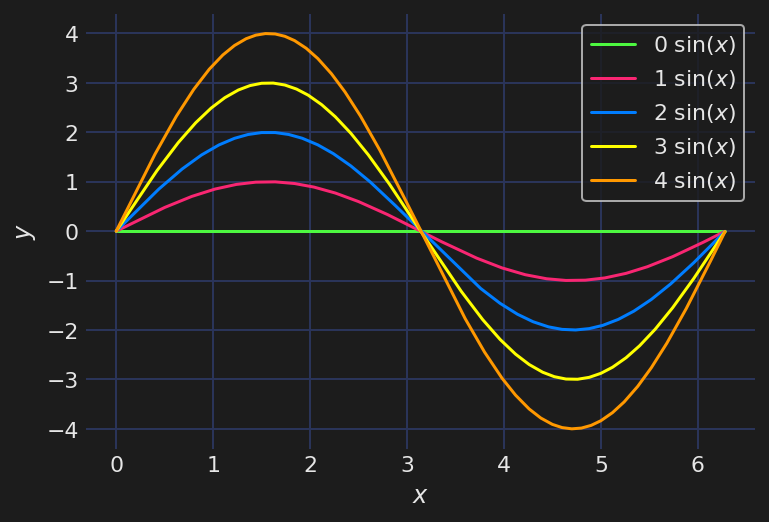

In [8]:
try:
    plt.style.use('molokai')
except:
    pass

fig, ax = plt.subplots()
x = np.arange(0, 2*np.pi, 0.02)
for i in range(5):
    _ = ax.plot(x, i * np.sin(x), label=f'{i} ' + r"$\sin(x)$")
    
_ = ax.legend(loc='best')
fig.set_facecolor('#1c1c1c')
_ = ax.set_xlabel(r"$x$")
_ = ax.set_ylabel(r"$y$")

#import tikzplotlib
#tikzplotlib.save("/Users/saforem2/Downloads/sin_tikz.tex")
# or
#tikzplotlib.save("mytikz.tex", flavor="context")a

Specify HMC dirs to look in for data

In [9]:
from config import LOGS_DIR
import glob
from pathlib import Path

hmc_dirs = []

# From `thetaGPU`:
#hmc_dir = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/')

# From local machine:
hmc_dir = os.path.abspath('/Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/')
hmc_dir = Path(hmc_dir)

hmc_dirs = [x for x in hmc_dir.rglob('*HMC_L16*') if x.is_dir()]

In [10]:
len(hmc_dirs)

237

 Specify L2HMC dirs (from JLSE and thetaGPU) containing data

In [11]:
from pathlib import Path

# From thetaGPU:
base_dir_thetaGPU = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/training/')
if os.path.isdir(base_dir_thetaGPU):
    l2hmc_dirs = _get_l2hmc_dirs(base_dir_thetaGPU)
    
# From local machine:
base_dir_local = os.path.abspath('/Users/saforem2/thetaGPU/training/')
if os.path.isdir(base_dir_local):
    l2hmc_dirs = _get_l2hmc_dirs(base_dir_local)
    
    
l2hmc_dirs = sorted(l2hmc_dirs)
len(l2hmc_dirs)

# ====
# Older training runs, no longer needed with new (better) results as of (12/05/2020)
# base_dir1 = os.path.abspath('/lus/theta-fs0/projects/DLHMC/thetaGPU/training_2020_11')
# l2hmc_dirs += _get_l2hmc_dirs(base_dir1)

Looking in /Users/saforem2/thetaGPU/training...


29

In [12]:
q_l2hmc, dqi_l2hmc = load_charge_data(l2hmc_dirs)
q_l2hmc.keys()

Looking in dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj...
......looking in run_dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/inference/L16_b2048__lf10_eps0208-2020-11-30-0625...
........loading data for (beta, num_steps, eps): (5.0, 10, 0.194)...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b2048__lf10_eps0194-2020-11-30-2123...
Looking in dir: /Users/saforem2/thetaGPU/training/2020_11_29/t16x16_b2048_lf10_bi4_bf5_4ranks/l2hmc-qcd/logs/GaugeModel_logs/2020_11/L16_b2048_lf10_bi4_bf5_dp02_clip500_sepNets_NCProj/LOADED/inference/L16_b2048__lf10_eps0194-2020-11-30-2129...
Looking i

dict_keys([5.0, 6.0, 7.0])

In [13]:
q_hmc, dqi_hmc = load_charge_data(hmc_dirs, hmc=True)
q_hmc.keys()

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf20_eps005-2020-12-01-0452...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf20_eps0025-2020-12-01-0449...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta7_lf20_eps01-2020-12-02-1922...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf20_eps025-2020-12-01-0509...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta6_lf10_eps0025-2020-12-02-1823...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta45_lf20_eps02-2020-12-01-0344...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf20_eps02-2020-12-01-0505...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta55_lf25_eps01-2020-12-01-0638...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta55_lf25_eps025-2020-12-01-0653...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta45_lf25_eps025-2020-12-01-0418...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta55_lf20_eps025-2020-12-01-0625...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta7_lf10_eps0025-2020-12-02-1827...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeMode

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta45_lf15_eps005-2020-11-30-2234...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta4_lf20_eps02-2020-11-30-2154...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta4_lf15_eps025-2020-11-30-2131...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta4_lf20_eps015-2020-11-30-2148...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta4_lf15_eps01-2020-11-30-2117...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta4_lf25_eps005-2020-11-30-2206...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_lo

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta6_lf10_eps03-2020-11-19-1324...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta5_lf10_eps005-2020-11-19-1254...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta4_lf10_eps02-2020-11-19-1353...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta5_lf10_eps02-2020-11-19-1427...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta6_lf10_eps015-2020-11-19-1441...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta45_lf10_eps03-2020-11-19-1251...
Looking in dir: /Us

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta45_lf10_eps005-2020-11-30-0857...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta4_lf10_eps02-2020-11-30-2109...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta6_lf10_eps025-2020-11-30-0831...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta5_lf10_eps025-2020-11-30-0756...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta4_lf10_eps025-2020-11-30-0716...
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta6_lf10_eps03-2020-11-30-0834...
Looking in dir: /

dict_keys([])

In [14]:
q_hmc = {}
dqi_hmc = {}

beta_conds = [
    lambda beta: beta < 4.0,
    lambda beta: beta == 5.5,
]

for hdir in hmc_dirs:
    print(f'Looking in dir: {hdir}')
    dqif = sorted(hdir.rglob('dq.z'))
    qf = sorted(hdir.rglob('charges.z'))
    pf = sorted(hdir.rglob('run_params.z'))
    if len(dqif) > 0:
        for dqif_, qf_, pf_ in zip(dqif, qf, pf):
            #print(f'......looking in run_dir: {rd}...')
            
            params = io.loadz(pf[0])
            beta = params['beta']
            eps = params['eps']
            num_steps = params['num_steps']
            
            for cond in beta_conds:
                if cond(beta):
                    continue
                
            def _update_dict(d, f):
                try:
                    d[beta].update({
                        (num_steps, eps): io.loadz(f)
                    })
                except KeyError:
                    d[beta] = {
                        (num_steps, eps): io.loadz(f)
                    }

                return d

            q_hmc = _update_dict(q_hmc, qf_)
            dqi_hmc = _update_dict(dqi_hmc, dqif_)

q_hmc = AttrDict(q_hmc)
dqi_hmc = AttrDict(dqi_hmc)

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf20_eps005-2020-12-01-0452
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf20_eps0025-2020-12-01-0449
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta7_lf20_eps01-2020-12-02-1922
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf20_eps025-2020-12-01-0509
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta6_lf10_eps0025-2020-12-02-1823
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta45_lf20_eps02-2020-12-01-0344
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta55_lf15_eps01-2020-12-01-0549
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf15_eps005-2020-12-01-0428
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf25_eps03-2020-12-01-0540
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta6_lf15_eps0025-2020-12-01-0659
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta5_lf15_eps03-2020-12-01-0447
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta6_lf20_eps0025-2020-12-01-0722
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_12/HMC_L16_b512_beta45_lf15_eps03-2020-12-01-0322
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta4_lf10_eps005-2020-11-30-2112
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta45_lf15_eps025-2020-11-30-2251
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta4_lf25_eps015-2020-11-30-2215
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta4_lf25_eps03-2020-11-30-2230
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/HMC_L16_b512_beta45_lf15_eps015-2020-11-30-2242
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta45_lf10_eps015-2020-11-19-1242
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta45_lf10_eps025-2020-11-19-1248
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta45_lf10_eps03-2020-11-19-1416
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta6_lf10_eps01-2020-11-19-1313
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta4_lf10_eps015-2020-11-19-1225
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-19/HMC_L16_b128_beta3_lf10_eps02-2020-11-19-1211
Looking in dir: /Users/saforem2/th

Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta5_lf10_eps03-2020-11-30-0759
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta55_lf10_eps01-2020-11-30-0804
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta55_lf10_eps015-2020-11-30-0808
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta45_lf10_eps025-2020-11-30-0737
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta4_lf10_eps015-2020-11-30-0843
Looking in dir: /Users/saforem2/thetaGPU/inference/hmc/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_11/2020-11-30/HMC_L16_b512_beta45_lf10_eps02-2020-11-30-0733
Looking in dir: /Users/saforem2/t

In [15]:
q_hmc.keys()

dict_keys([5.0, 7.0, 6.0, 4.5, 5.5, 4.0, 3.0])

In [16]:
from copy import deepcopy
q_hmc_copy = deepcopy(q_hmc)
q_l2hmc_copy = deepcopy(q_l2hmc)

In [17]:
q_hmc = {k: v for k, v in q_hmc.items() if k > 4.5}
q_hmc.keys()

dict_keys([5.0, 7.0, 6.0, 5.5])

In [19]:
q_l2hmc[5.0].keys()

dict_keys([(10, 0.19424471), (10, 0.19657207)])

In [20]:
q_hmc[5.0].keys()

dict_keys([(20, 0.05), (20, 0.025), (20, 0.25), (15, 0.1), (20, 0.1), (15, 0.2), (25, 0.2), (20, 0.3), (25, 0.025), (15, 0.05), (25, 0.3), (15, 0.3), (20, 0.2), (15, 0.25), (25, 0.25), (25, 0.15), (20, 0.15), (15, 0.025), (15, 0.15), (25, 0.05), (10, 0.025), (25, 0.1), (10, 0.3), (10, 0.1), (10, 0.2), (10, 0.25), (10, 0.05), (10, 0.15)])

In [21]:
# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Following the suggestion from Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

In [24]:
from config import MARKERS, LOGS_DIR, FIGSIZE, TEX_FIGURES_DIR, PLOTS_DIR
from utils.data_utils import therm_arr
from utils.plotting_utils import set_size

H, W = FIGSIZE

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')
#plt.Axes.set_yticklabels()

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=(
   r"""
   \usepackage{amsmath}
   \usepackage[sups]{XCharter}
   \usepackage[scaled=1.04,varqu,varl]{inconsolata}
   \usepackage[type1]{cabin}
   \usepackage[charter,vvarbb,scaled=1.07]{newtxmath}
   \usepackage[cal=boondoxo]{mathalfa}
   """
))

In [ ]:
def calc_autocorr(y):
    N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 20)).astype(int)
    new = np.empty(len(N))
    for i, n in enumerate(N):
        new[i] = autocorr_new(y[:, :n])
        
    return N, new

In [26]:
#n_l2hmc = []
tint_l2hmc = {}
for key, val in q_l2hmc[5.0].items():
    qarr, _ = therm_arr(val)
    qarr = qarr.T
    n, tint = calc_autocorr(qarr)
    #n_l2hmc[key] = n
    tint_l2hmc[key] = {
        'N': n,
        'tint': tint,
    }
    #tint_l2hmc[key] = tint
    
#n_hmc = []
tint_hmc = {}
for key, val in q_hmc[5.0].items():
    qarr, _ = therm_arr(val)
    qarr = qarr.T
    n, tint = calc_autocorr(qarr)
    tint_hmc[key] = {
        'N': n,
        'tint': tint,
    }
    #n_hmc[key] = n
    #tint_hmc[key] = tint
   

/Users/saforem2/opt/anaconda3/envs/l2hmc1/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/saforem2/opt/anaconda3/envs/l2hmc1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
tint_l2hmc = {}
for key, val in q_l2hmc.items():
    tint_l2hmc[key] = {}
    for k, v in val.items():
        qarr, _ = therm_arr(v, therm_frac=0.1)
        qarr = qarr.T
        n, tint = calc_autocorr(qarr)
        tint_l2hmc[key][k] = {
            'N': n,
            'tint': tint,
        }
        
tint_hmc = {}
for key, val in q_hmc.items():
    tint_hmc[key] = {}
    for k, v in val.items():
        qarr, _ = therm_arr(v, therm_frac=0.1)
        qarr = qarr.T
        n, tint = calc_autocorr(qarr)
        tint_hmc[key][k] = {
            'N': n,
            'tint': tint,
        }

/Users/saforem2/opt/anaconda3/envs/l2hmc1/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/Users/saforem2/opt/anaconda3/envs/l2hmc1/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until


In [40]:
beta_str = {
    5.0: r"$5$",
    6.0: r"$6$",
    7.0: r"$7$",
}
def plot_autocorrs(beta, l2hmc_data, hmc_data):
    fig, ax = plt.subplots()
    for idx, (key, val) in enumerate(l2hmc_data.items()):
        if idx == 0:
            label = 'L2HMC'
        else:
            label = None

        _ = ax.loglog(val['N'], val['tint'], '.-', color='deeppink', label=label) # , label=f'L2HMC: {str(key)}')

    for idx, (key, val) in enumerate(hmc_data.items()):
        if idx == 0:
            label = 'HMC'
        else:
            label = None

        _ = ax.loglog(val['N'], val['tint'], ',--', lw=0.8, alpha=0.7, color='k', label=label) #, label=f'HMC: {str(key)}')

    _ = ax.legend(loc='best')
    _ = ax.set_title(r"$\beta = $" + beta_str[beta])
    _ = ax.set_xlabel(r"Number of samples, $N$")
    _ = ax.set_ylabel(r"$\tau_{\mathrm{int}}$ estimates")

In [41]:
betas = list(tint_l2hmc.keys())
betas

[5.0, 6.0, 7.0]

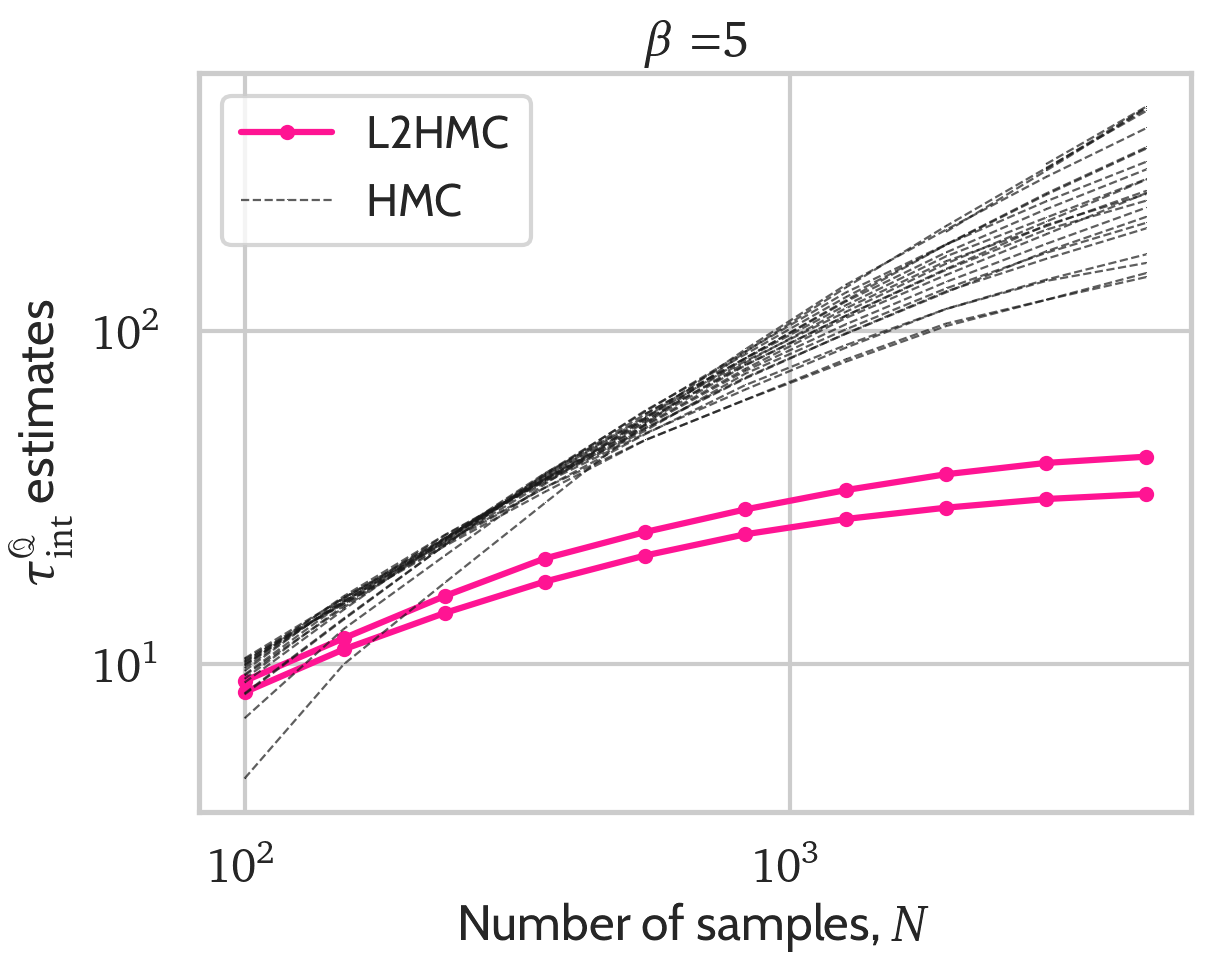

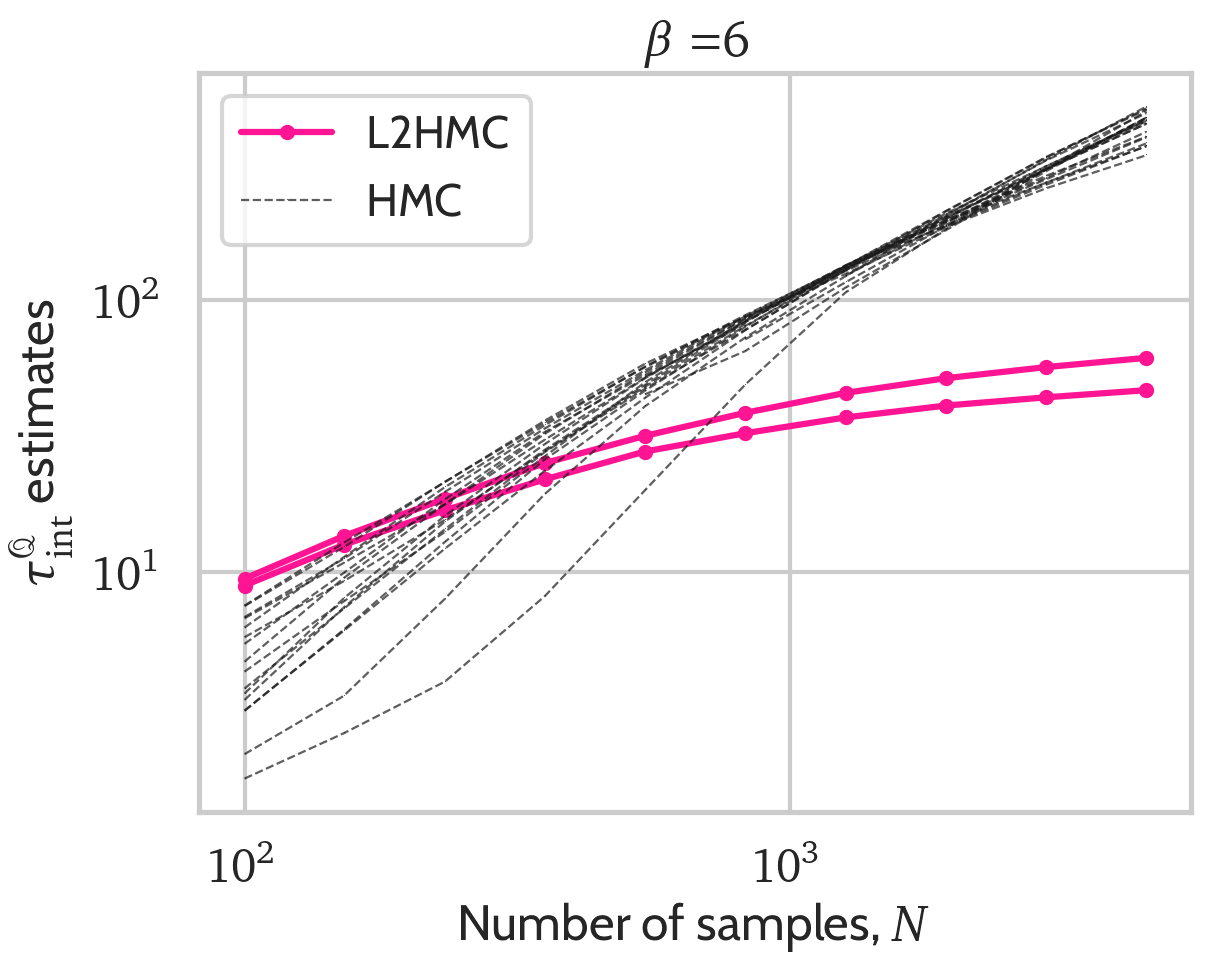

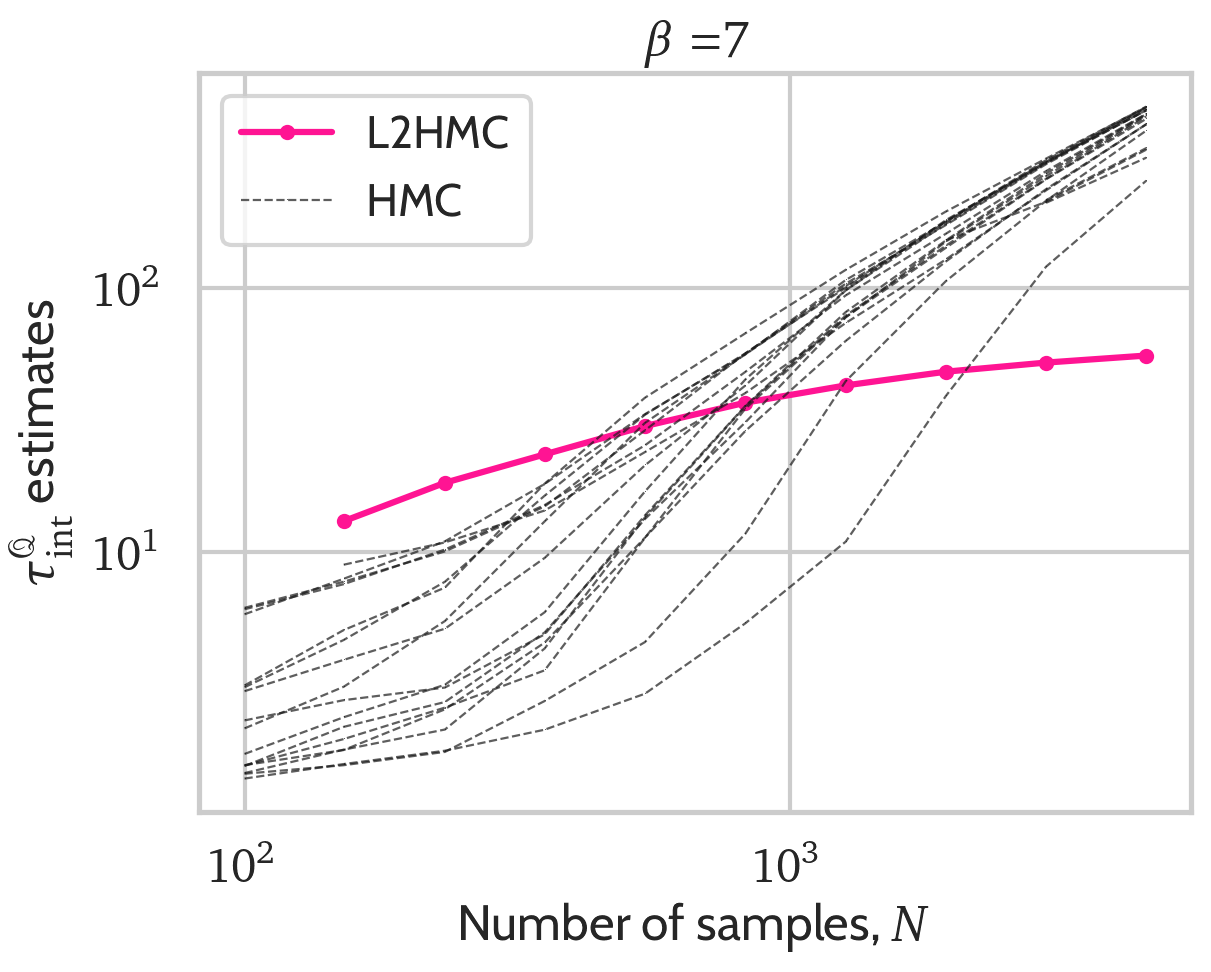

In [42]:
for beta in betas:
    l2hmc_data = tint_l2hmc[beta]
    hmc_data = tint_hmc[beta]
    plot_autocorrs(beta, l2hmc_data, hmc_data)

In [45]:

tint_data = {}
for beta in betas:
    tint_data[beta] = {
        'l2hmc': {},
        'hmc': {},
    }
    l2hmc_data = tint_l2hmc[beta]
    for key, val in l2hmc_data.items():
        if np.isfinite(val['tint'][-1]):
            tint_data[beta]['l2hmc'][key] = val['tint'][-1]
        
    hmc_data = tint_hmc[beta]
    for key, val in hmc_data.items():
        if np.isfinite(val['tint'][-1]):
            tint_data[beta]['hmc'][key] = val['tint'][-1]

In [50]:
tint_data[5.0]

{'l2hmc': {(10, 0.19424471): 32.42324762078313,
  (10, 0.19657207): 41.99935304654701},
 'hmc': {(20, 0.05): 247.04846892849645,
  (20, 0.025): 354.27222141795573,
  (20, 0.25): 470.75259927519056,
  (15, 0.1): 211.9542142162847,
  (20, 0.1): 170.3860279394762,
  (15, 0.2): 285.7306362466262,
  (25, 0.2): 235.43679056318734,
  (25, 0.025): 306.6311259280697,
  (15, 0.05): 286.7883812656844,
  (20, 0.2): 260.39514265259226,
  (25, 0.25): 473.67947019921866,
  (25, 0.15): 145.5855411536548,
  (20, 0.15): 160.52351876775026,
  (15, 0.025): 408.0587352814267,
  (15, 0.15): 203.97178689768876,
  (25, 0.05): 220.87301494016276,
  (10, 0.025): 459.5841722953183,
  (25, 0.1): 149.67182570929816,
  (10, 0.1): 264.33878551068165,
  (10, 0.2): 323.3755128622983,
  (10, 0.25): 467.1919743915742,
  (10, 0.05): 357.2475356726058,
  (10, 0.15): 258.7048269094397}}

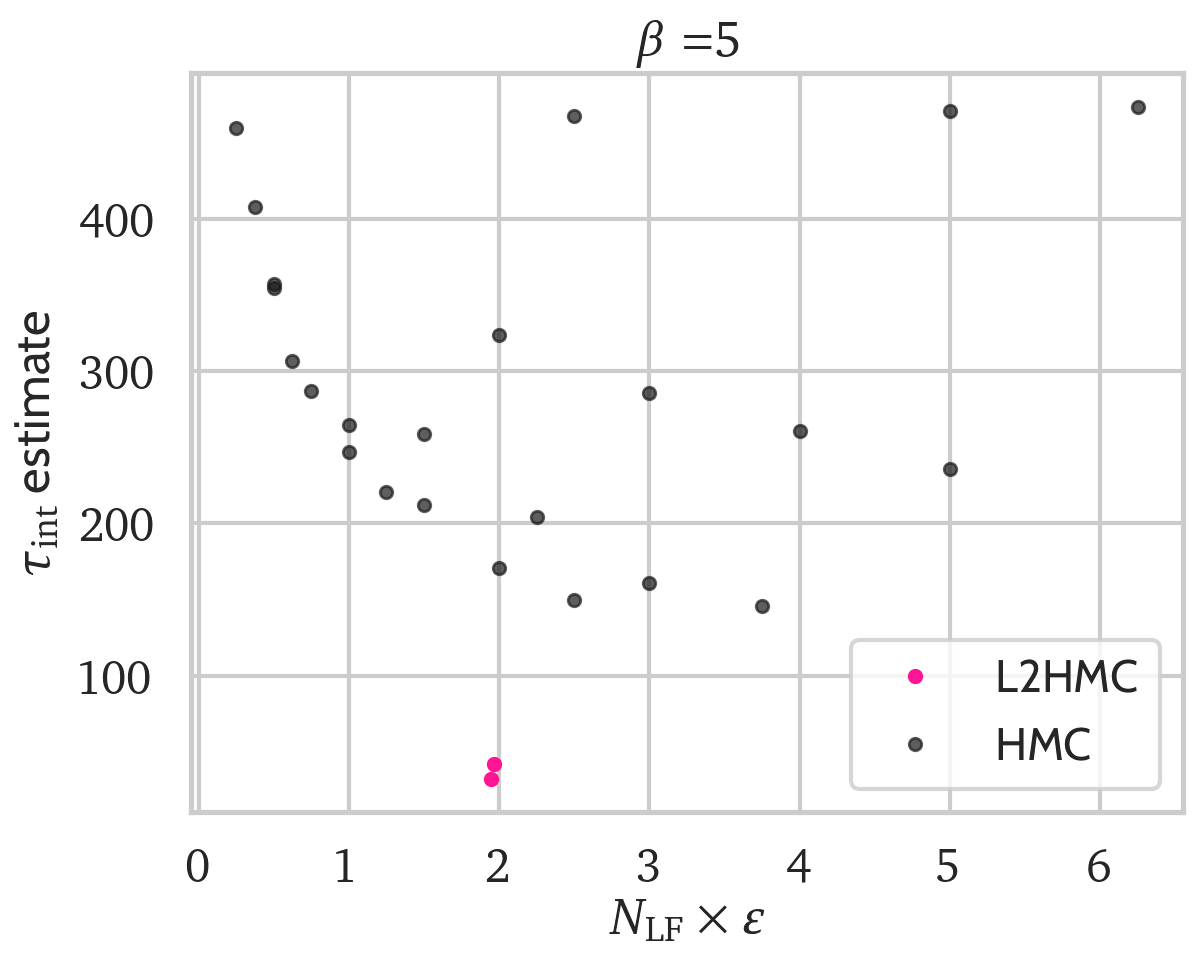

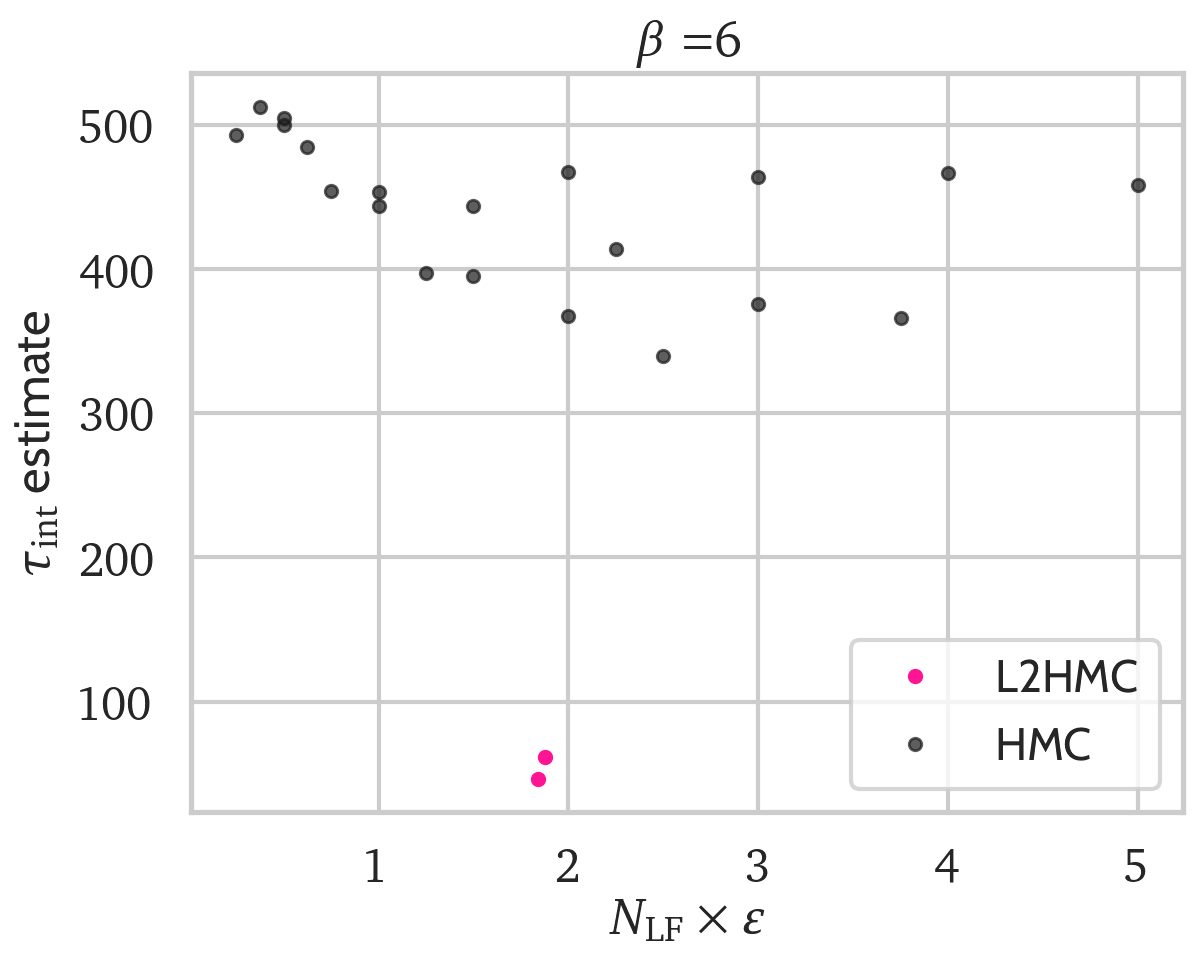

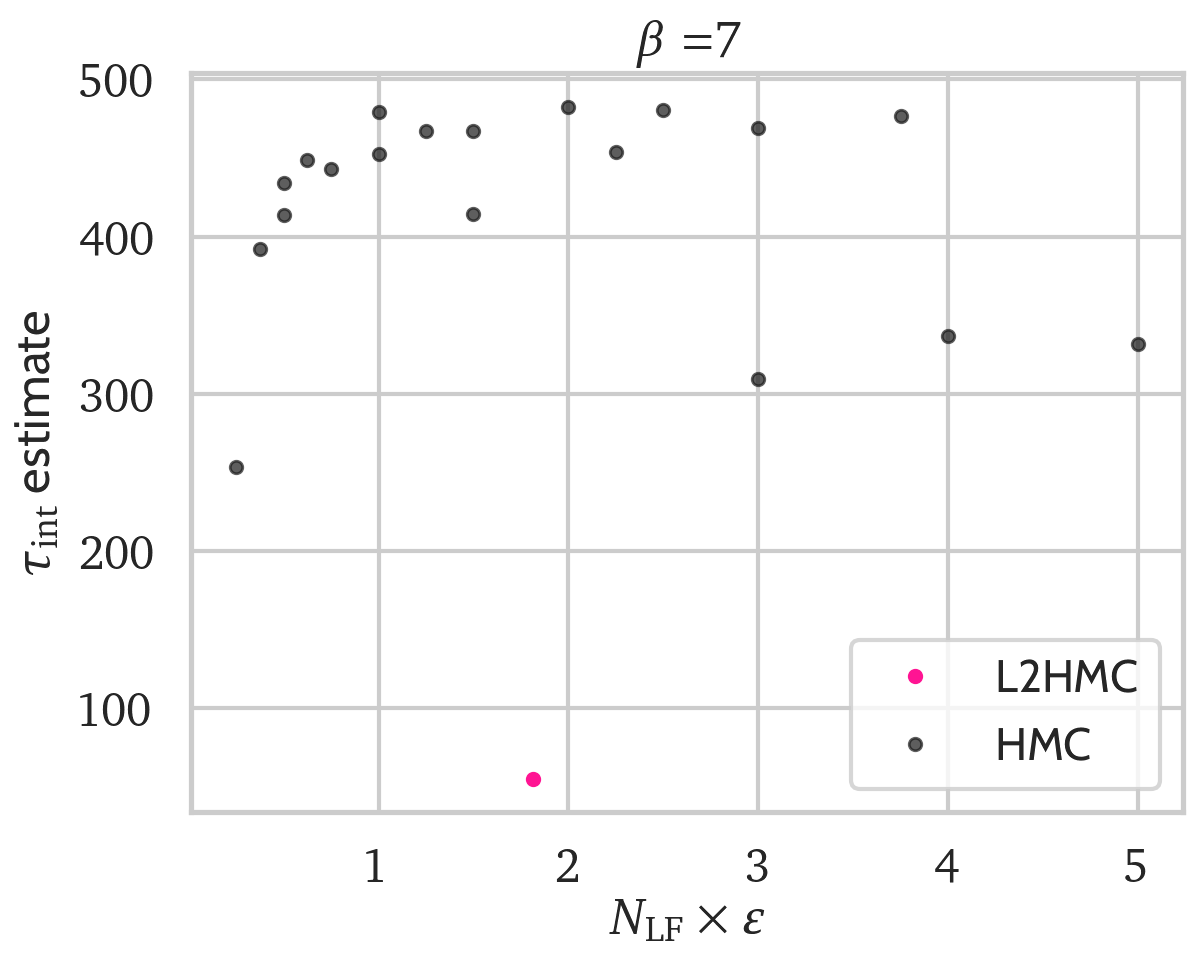

In [62]:
best_l2hmc = {}
best_hmc = {}
err_l2hmc = {}
err_hmc = {}

for key, val in tint_data.items():
    fig, ax = plt.subplots()
    beta = key
    l2hmc_data = val['l2hmc']
    err_l2hmc[key] = np.std(np.array(list(l2hmc_data.values())))
    best = np.inf
    for idx, (k, v) in enumerate(l2hmc_data.items()):
        label = 'L2HMC' if idx == 0 else None
            
        lf, eps = k
        traj_len = lf * eps
        
        if v < best:
            best_l2hmc[key] = v
            
        _ = ax.plot(traj_len, v, '.', label=label, color='deeppink')
        
    hmc_data = val['hmc']
    err_hmc[key] = np.std(np.array(list(hmc_data.values())))
    best = np.inf
    for idx, (k, v) in enumerate(hmc_data.items()):
        label = 'HMC' if idx == 0 else None
        lf, eps = k
        traj_len = lf * eps
        
        if v < best:
            best_hmc[key] = v
        
        _ = ax.plot(traj_len, v, '.', color='k', label=label, alpha=0.7, lw=0.8)
        
    _ = ax.set_xlabel(r"$N_{\mathrm{LF}} \times \varepsilon$")
    _ = ax.set_ylabel(r"$\tau_{\mathrm{int}}$ estimate")
    _ = ax.set_title(r"$\beta=$" + beta_str[beta])
    _ = ax.legend(loc='lower right')

In [58]:
best_hmc

{5.0: 258.7048269094397, 6.0: 499.81270535658945, 7.0: 331.9111110932936}

In [59]:
best_l2hmc

{5.0: 41.99935304654701, 6.0: 61.185750789796515, 7.0: 55.363324421975726}

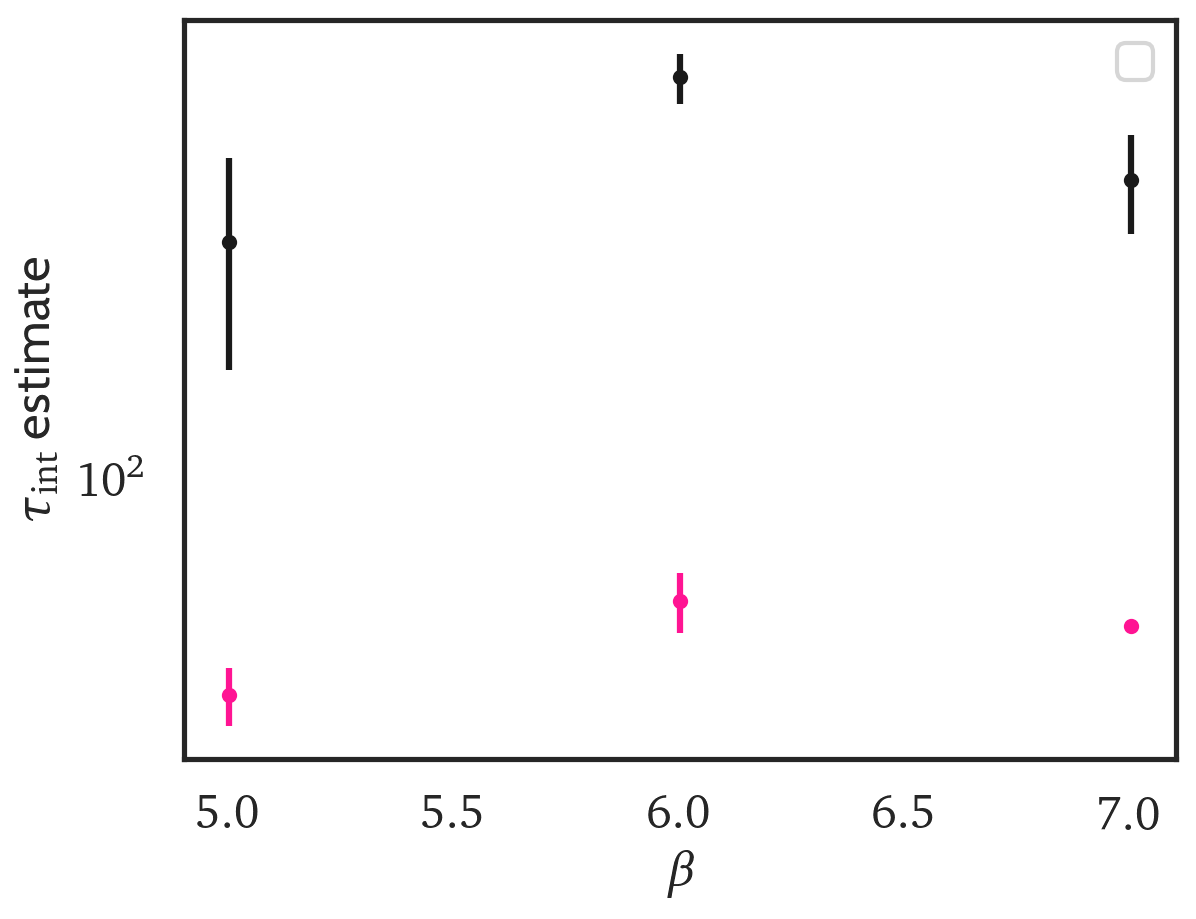

In [65]:
sns.set_style('white')

fig, ax = plt.subplots()
for idx, (key, val) in enumerate(best_l2hmc.items()):
    label = 'L2HMC' if idx == 0 else None
    _ = ax.errorbar(key, val, yerr=err_l2hmc[key], marker='.', color='deeppink')
    
for idx, (key, val) in enumerate(best_hmc.items()):
    label = 'HMC' if idx == 0 else None
    _ = ax.errorbar(key, val, yerr=err_hmc[key], marker='.', color='k')
    
_ = ax.set_yscale('log')
_ = ax.set_xlabel(r"$\beta$")
_ = ax.set_ylabel(r"$\tau_{\mathrm{int}}$ estimate")
#_ = ax.set_title(r"$\beta=$" + beta_str[beta])
_ = ax.legend(loc='best')


In [51]:
%debug

> <ipython-input-49-46a813da7a4e>(12)<module>()
     10         _ = ax.plot(traj_len, val, '.', label=label, color='deeppink')
     11 
---> 12     hmc_data = val['hmc']
     13     for idx, (key, val) in enumerate(hmc_data.items()):
     14         label = 'HMC' if idx == 0 else None

ipdb> key
(10, 0.19657207)
ipdb> q


In [ ]:
#y = q[None, :]
y = qarr
#y = qarr[0]
print(y.shape)
# Compute the estimators for a few different chain lengths
N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
#gw2010 = np.empty(len(N))
new = np.empty(len(N))
for i, n in enumerate(N):
    #gw2010[i] = autocorr_gw2010(y[:, :n])
    new[i] = autocorr_new(y[:, :n])
    
    
y_hmc = qarr_hmc
#y = qarr[0]
print(y_hmc.shape)
# Compute the estimators for a few different chain lengths
N_hmc = np.exp(np.linspace(np.log(100), np.log(y_hmc.shape[1]), 10)).astype(int)
#gw2010_hmc = np.empty(len(N_hmc))
new_hmc = np.empty(len(N_hmc))
for i, n in enumerate(N_hmc):
    #gw2010_hmc[i] = autocorr_gw2010(y_hmc[:, :n])
    new_hmc[i] = autocorr_new(y_hmc[:, :n])

# Plot the comparisons
#plt.loglog(N, gw2010, "o-", label="G\&W 2010")
plt.loglog(N, new, "o-", label="L2HMC")
plt.loglog(N_hmc, new_hmc, "o-", label="HMC")
ylim = plt.gca().get_ylim()
#plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
#plt.axhline(true_tau, color="k", label="truth", zorder=-100)
plt.ylim(ylim)
plt.xlabel("number of samples, $N$")
plt.ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);

In [40]:
q_hmc[5.0].keys()

dict_keys([(20, 0.05), (20, 0.025), (20, 0.25), (15, 0.1), (20, 0.1), (15, 0.2), (25, 0.2), (20, 0.3), (25, 0.025), (15, 0.05), (25, 0.3), (15, 0.3), (20, 0.2), (15, 0.25), (25, 0.25), (25, 0.15), (20, 0.15), (15, 0.025), (15, 0.15), (25, 0.05), (10, 0.025), (25, 0.1), (10, 0.3), (10, 0.1), (10, 0.2), (10, 0.25), (10, 0.05), (10, 0.15)])

In [ ]:
q_hmc[5.0][(20, 0.05)]

In [16]:
dqi_stats_l2hmc, dqi_avgs_l2hmc, dqi_errs_l2hmc = dq_stats(dqi_l2hmc, reps=100, therm_frac=0.5)

------------------------------------------------------------------------------------------------------------------------
key: 5.0...
.....key, val.shape: (10, 0.19424471), (5000, 2048)
.....key, therm_arr.shape: (10, 0.19424471), (2500, 2048)
.....key, avg: (10, 0.19424471), 0.12506499886512756 +/- -0.014034612425984958
.....key, val.shape: (10, 0.19657207), (5000, 2048)
.....key, therm_arr.shape: (10, 0.19657207), (2500, 2048)
.....key, avg: (10, 0.19657207), 0.10240905731916428 +/- -0.012410583155360652
------------------------------------------------------------------------------------------------------------------------
key: 6.0...
.....key, val.shape: (10, 0.18413678), (5000, 2048)
.....key, therm_arr.shape: (10, 0.18413678), (2500, 2048)
.....key, avg: (10, 0.18413678), 0.07840519398450851 +/- -0.010606209880734237
.....key, val.shape: (10, 0.187783), (5000, 2048)
.....key, therm_arr.shape: (10, 0.187783), (2500, 2048)
.....key, avg: (10, 0.187783), 0.05909442901611328 +/- -0.009

In [17]:
dqi_stats_hmc, dqi_avgs_hmc, dqi_errs_hmc = dq_stats(dqi_hmc, reps=100, therm_frac=0.5)

------------------------------------------------------------------------------------------------------------------------
key: 5.0...
.....key, val.shape: (20, 0.05), (5000, 512)
.....key, therm_arr.shape: (20, 0.05), (2500, 512)
.....key, avg: (20, 0.05), 0.014459621161222458 +/- -0.004154317691268261
.....key, val.shape: (20, 0.025), (5000, 512)
.....key, therm_arr.shape: (20, 0.025), (2500, 512)
.....key, avg: (20, 0.025), 0.007725532166659832 +/- -0.003002356036324596
.....key, val.shape: (20, 0.25), (5000, 512)
.....key, therm_arr.shape: (20, 0.25), (2500, 512)
.....key, avg: (20, 0.25), 0.0006556513835676014 +/- -0.000562246875882748
.....key, val.shape: (15, 0.1), (5000, 512)
.....key, therm_arr.shape: (15, 0.1), (2500, 512)
.....key, avg: (15, 0.1), 0.017396004870533943 +/- -0.004640591166366902
.....key, val.shape: (20, 0.1), (5000, 512)
.....key, therm_arr.shape: (20, 0.1), (2500, 512)
.....key, avg: (20, 0.1), 0.02262517437338829 +/- -0.005283789071881982
.....key, val.shape:

.....key, avg: (25, 0.3), 0.0 +/- 0.0
.....key, val.shape: (10, 0.05), (5000, 512)
.....key, therm_arr.shape: (10, 0.05), (2500, 512)
.....key, avg: (10, 0.05), 0.00020307203521952033 +/- -0.00019996805792548837
.....key, val.shape: (15, 0.25), (5000, 512)
.....key, therm_arr.shape: (15, 0.25), (2500, 512)
.....key, avg: (15, 0.25), 9.007033077068627e-05 +/- -9.007032933992844e-05
.....key, val.shape: (10, 0.15), (5000, 512)
.....key, therm_arr.shape: (10, 0.15), (2500, 512)
.....key, avg: (10, 0.15), 0.00018235755851492286 +/- -0.00018028154873239166
.....key, val.shape: (25, 0.05), (5000, 512)
.....key, therm_arr.shape: (25, 0.05), (2500, 512)
.....key, avg: (25, 0.05), 0.00040710068424232304 +/- -0.0003882862109917437
.....key, val.shape: (10, 0.1), (5000, 512)
.....key, therm_arr.shape: (10, 0.1), (2500, 512)
.....key, avg: (10, 0.1), 0.0002535659004934132 +/- -0.0002473854514619775
.....key, val.shape: (25, 0.1), (5000, 512)
.....key, therm_arr.shape: (25, 0.1), (2500, 512)
.....k

.....key, avg: (10, 0.025), 0.009911634027957916 +/- -0.003393537432424409
.....key, val.shape: (25, 0.3), (5000, 512)
.....key, therm_arr.shape: (25, 0.3), (2500, 512)
.....key, avg: (25, 0.3), 1.0687499525374733e-05 +/- -1.0687498956940544e-05
.....key, val.shape: (20, 0.1), (5000, 512)
.....key, therm_arr.shape: (20, 0.1), (2500, 512)
.....key, avg: (20, 0.1), 0.05803427845239639 +/- -0.0085259897807191
.....key, val.shape: (15, 0.3), (5000, 512)
.....key, therm_arr.shape: (15, 0.3), (2500, 512)
.....key, avg: (15, 0.3), 0.0003041797608602792 +/- -0.0003036992515365718
.....key, val.shape: (15, 0.25), (5000, 512)
.....key, therm_arr.shape: (15, 0.25), (2500, 512)
.....key, avg: (15, 0.25), 0.0046217842027544975 +/- -0.0023142495529257603
.....key, val.shape: (15, 0.15), (5000, 512)
.....key, therm_arr.shape: (15, 0.15), (2500, 512)
.....key, avg: (15, 0.15), 0.04855457693338394 +/- -0.007924778551205235
.....key, val.shape: (15, 0.05), (5000, 512)
.....key, therm_arr.shape: (15, 0.0

.....key, avg: (20, 0.2), 0.10552404075860977 +/- -0.012289390101796013
.....key, val.shape: (15, 0.25), (5000, 512)
.....key, therm_arr.shape: (15, 0.25), (2500, 512)
.....key, avg: (15, 0.25), 0.02198203094303608 +/- -0.005783857405650097
.....key, val.shape: (20, 0.15), (5000, 512)
.....key, therm_arr.shape: (20, 0.15), (2500, 512)
.....key, avg: (20, 0.15), 0.1553160399198532 +/- -0.014290220741895605
.....key, val.shape: (15, 0.1), (5000, 512)
.....key, therm_arr.shape: (15, 0.1), (2500, 512)
.....key, avg: (15, 0.1), 0.11269626021385193 +/- -0.011744904098304683
.....key, val.shape: (25, 0.05), (5000, 512)
.....key, therm_arr.shape: (25, 0.05), (2500, 512)
.....key, avg: (25, 0.05), 0.11259154230356216 +/- -0.011625520487723404
.....key, val.shape: (25, 0.1), (5000, 512)
.....key, therm_arr.shape: (25, 0.1), (2500, 512)
.....key, avg: (25, 0.1), 0.1821298748254776 +/- -0.015154401064501138
.....key, val.shape: (20, 0.25), (5000, 512)
.....key, therm_arr.shape: (20, 0.25), (2500, 

In [69]:
%store q_hmc
%store q_l2hmc
%store dqi_hmc
%store dqi_l2hmc

Stored 'q_hmc' (AttrDict)
Stored 'q_l2hmc' (AttrDict)
Stored 'dqi_hmc' (AttrDict)
Stored 'dqi_l2hmc' (AttrDict)


In [73]:
hmc_df = pd.DataFrame().from_dict({
    key: {
        (k[0], k[1]): np.squeeze(v.flatten()) for k, v in val.items()
    } for key, val in q_hmc.items()
})
hmc_df.head()

5.0  \
20 0.050  [-1.0000002, 1.9999996, -5.3123694e-07, -1.062...   
   0.025  [-1.0000006, -7.0, -3.0, 2.0000007, -6.071279e...   
   0.250  [3.7945494e-08, -1.8972747e-07, -1.0000004, 2....   
15 0.100  [-0.99999976, -1.5178198e-07, 0.9999998, -0.99...   
20 0.100  [-1.0000001, -1.1383648e-07, -6.071279e-07, 0....   

                                                        7.0  \
20 0.050  [-1.9999992, -1.0000001, 0.9999996, 0.99999946...   
   0.025  [1.0000002, -3.0000002, -4.0000005, -1.9999995...   
   0.250  [-1.0000001, -0.99999946, 4.9999995, -3.000000...   
15 0.100  [0.99999976, -1.0000005, 0.99999994, 0.9999996...   
20 0.100  [0.99999946, 2.0, 2.0, 0.9999992, -1.9999996, ...   

                                                        6.0  \
20 0.050  [-1.0000002, -1.9999992, -1.1383648e-07, -2.00...   
   0.025  [-0.99999994, -2.0000002, 1.9999999, -2.0, -1....   
   0.250  [0.99999994, -0.99999994, 0.99999946, -3.00000...   
15 0.100  [1.0, 0.9999996, -1.0000007, 9.865828e-07, -1....   
20 0.100  [3.7945494e-08, 2.9999993, -2.0000007, 0.99999...   

                                                        4.5  \
20 0.050  [-3.7945495e-07, 1.9999999, 1.9999999, -3.0356...   
   0.025  [1.9999999, 7.589099e-08, 1.9999994, -3.999999...   
   0.250  [-1.0, 3.0000005, 0.99999994, -5.8815516e-07, ...   
15 0.100  [-1.9999996, -7.589099e-07, 0.9999996, 0.99999...   
20 0.100  [-2.0000002, 1.0000002, -6.2610064e-07, -1.999...   

                                                        5.5  \
20 0.050  [-2.2767296e-07, -1.0000002, 0.9999995, -1.214...   
   0.025  [-0.9999997, 1.0000001, -1.0000001, -2.0000002...   
   0.250  [-1.0000001, -6.450734e-07, -2.0000005, 1.0, 2...   
15 0.100  [-2.0000002, -0.99999946, 1.9999995, -2.999999...   
20 0.100  [-8.537736e-07, -1.0000008, 1.0000002, -1.0000...   

                                                        4.0  3.0  
20 0.050  [-1.0000005, -3.7945494e-08, -0.9999995, -6.45...  NaN  
   0.025                                                NaN  NaN  
   0.250  [-3.4150943e-07, -2.0000002, 0.99999946, 5.312...  NaN  
15 0.100  [-1.9999996, 1.9999996, 2.9999995, 4.553459e-0...  NaN  
20 0.100  [1.0000002, -2.0000002, -1.0, 0.99999976, -3.0...  NaN

In [78]:
l2hmc_df = xr.DataArray({
    key: {
        (k[0], k[1]): np.squeeze(v.flatten()) for k, v in val.items()
    } for key, val in q_l2hmc.items()
})
l2hmc_df

<xarray.DataArray ()>
array(<built-in method values of dict object at 0x1042d35780>,
      dtype=object)

In [82]:
import xarray as xr
from utils.data_utils import therm_arr

therm_frac = 0.25

#hmc_xarr = {}
hmc_xarr = []
for beta, data in q_hmc.items():
    if beta not in q_l2hmc.keys():
        continue
        
    for k, v in data.items():
        num_steps, num_chains = v.shape
        arr, steps = therm_arr(v, therm_frac=therm_frac)
        chains = np.arange(num_chains)
        coords = {
            'chain': chains,
            'draw': steps,
            'beta': beta,
            'leapfrog': k[0],
            'eps': k[1],
        }
        hmc_xarr.append(xr.DataArray(arr.T, dims=['chain', 'draw'], coords=coords))

In [84]:
xr.merge(hmc_xarr)

ValueError: unable to convert unnamed DataArray to a Dataset without providing an explicit name

In [ ]:
hmc_xarr

In [1]:
import xarray as xr

dataset = xr.Dataset({'l2hmc': l2hmc_df, 'hmc': hmc_df})
dataset

NameError: name 'l2hmc_df' is not defined

### Save boostrapped tunneling rate stats to avoid having to recompute

In [18]:
from config import LOGS_DIR

timestamp = io.get_timestamp()
date = io.get_timestamp('%Y-%m-%d')
outdir = os.path.join(LOGS_DIR, 'tunneling_rates', date)
datadir = os.path.join(outdir, 'data')
figsdir = os.path.join(outdir, 'figs')
io.check_else_make_dir([outdir, datadir, figsdir])

# +-------+
# | L2HMC |
# +-------+
intfile_l2hmc = os.path.join(f'dq_int_stats_l2hmc_{timestamp}.z')
io.savez(dqi_stats_l2hmc, intfile_l2hmc, name='dq_int_stats_l2hmc')

#sinfile_l2hmc = os.path.join(f'dq_sin_stats_l2hmc_{timestamp}.z')
#io.savez(dqs_stats_l2hmc, sinfile_l2hmc, name='dq_sin_stats_l2hmc')

# +-----+
# | HMC |
# +-----+
intfile_hmc = os.path.join(f'dq_int_stats_hmc_{timestamp}.z')
io.savez(dqi_stats_hmc, intfile_hmc, name='dq_int_stats_hmc')

#sinfile_hmc = os.path.join(f'dq_sin_stats_hmc_{timestamp}.z')
#io.savez(dqs_stats_hmc, sinfile_hmc, name='dq_sin_stats_hmc')

Creating directory: /Users/saforem2/l2hmc-qcd/logs/tunneling_rates/2020-12-09
Creating directory: /Users/saforem2/l2hmc-qcd/logs/tunneling_rates/2020-12-09/data
Creating directory: /Users/saforem2/l2hmc-qcd/logs/tunneling_rates/2020-12-09/figs
Saving dq_int_stats_l2hmc to /Users/saforem2/l2hmc-qcd/l2hmc-qcd/notebooks/dq_int_stats_l2hmc_2020-12-09-235915.z.
Saving dq_int_stats_hmc to /Users/saforem2/l2hmc-qcd/l2hmc-qcd/notebooks/dq_int_stats_hmc_2020-12-09-235915.z.


In [19]:
from config import LOGS_DIR
import utils.file_io as io

outdir = os.path.join(LOGS_DIR, 'tunneling_rates', date)
datadir = os.path.join(outdir, 'data')
figsdir = os.path.join(outdir, 'figs')

In [20]:
def load_dq_data(datafiles):
    data = {}
    for datafile in datafiles:
        print(f'Loading data from: {datafile}...')
        key = '_'.join(datafile.split('/')[-1].split('_')[:4])
        val = io.loadz(datafile)
        data[key] = val
    return  data

### Scatter plot of $\langle \delta\mathcal{Q}\rangle$ vs $\varepsilon$ for HMC, L2HMC

In [21]:
dqi_stats_l2hmc = dict(sorted(dqi_stats_l2hmc.items(), key=lambda x: x[0]))
dqih = dict(sorted(dqi_stats_hmc.items(), key=lambda x: x[0]))
dqil = dict(sorted(dqi_stats_l2hmc.items(), key=lambda x: x[0]))

print(f'hmc keys: {dqi_stats_hmc.keys()}')
print(f'l2hmc keys: {dqi_stats_l2hmc.keys()}')

hmc keys: dict_keys([5.0, 7.0, 6.0, 4.5, 5.5, 4.0, 3.0])
l2hmc keys: dict_keys([5.0, 6.0, 7.0])


In [22]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)

In [23]:
%matplotlib inline

In [35]:
%matplotlib notebook

In [37]:
dqih.keys()

dict_keys([3.0, 4.0, 4.5, 5.0, 5.5, 6.0, 7.0])

In [38]:
dqih[5.0].keys()

dict_keys([(20, 0.05), (20, 0.025), (20, 0.25), (15, 0.1), (20, 0.1), (15, 0.2), (25, 0.2), (20, 0.3), (25, 0.025), (15, 0.05), (25, 0.3), (15, 0.3), (20, 0.2), (15, 0.25), (25, 0.25), (25, 0.15), (20, 0.15), (15, 0.025), (15, 0.15), (25, 0.05), (10, 0.025), (25, 0.1), (10, 0.3), (10, 0.1), (10, 0.2), (10, 0.25), (10, 0.05), (10, 0.15)])

In [ ]:
dqih[]

In [50]:
axes1.shape

(3,)

In [51]:
axes_grid.shape

(2, 3)

In [2]:
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset, inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import copy
import matplotlib.pyplot as plt 
import seaborn as sns
from config import MARKERS, LOGS_DIR, FIGSIZE, TEX_FIGURES_DIR, PLOTS_DIR
from utils.plotting_utils import set_size

H, W = FIGSIZE

plt.style.use('default')
sns.set_context('talk')
sns.set_style('whitegrid')
sns.set_palette('bright')
#plt.Axes.set_yticklabels()

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=(
   r"""
   \usepackage{amsmath}
   \usepackage[sups]{XCharter}
   \usepackage[scaled=1.04,varqu,varl]{inconsolata}
   \usepackage[type1]{cabin}
   \usepackage[charter,vvarbb,scaled=1.07]{newtxmath}
   \usepackage[cal=boondoxo]{mathalfa}
   """
))

COLORS = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
MARKERS = ['x', '', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']

leapfrogs_l2hmc = [10]  # , 15, 20]
leapfrogs_hmc = [10, 15, 20, 25, 30]
keep_betas = [5., 6., 7.]
eps_cond = lambda eps: eps < 0.29


beta_dict = {
    2.0: r"$2$",
    3.0: r"$3$",
    4.0: r"$4$",
    4.5: r"$4.5$",
    5.0: r"$5$",
    6.0: r"$6$",
    7.0: r"$7$",
}

lf_dict = {
    10: r"$10$",
    15: r"$15$",
    20: r"$20$",
    25: r"$25$",
    30: r"$30$",
}

plot_kwargs = {
    'markersize': 8.,
    'lw': 2.,
    'alpha': 1.,
    #'marker': '.',
}

plot_kwargs_hmc = copy.deepcopy(plot_kwargs)
plot_kwargs_l2hmc = copy.deepcopy(plot_kwargs)

plot_kwargs_l2hmc.update({'ls': '', 'color': 'k', 'marker': 'o'})
plot_kwargs_hmc.update({'ls': '-', 'marker': '.'})

lf_colors = plt.cm.get_cmap('Greys', 16)
lf_colors_l2hmc = 10 * ['#87ff00']

HMC_COLORS = np.array(9 * ['C1'])
L2HMC_COLORS = np.array(9 * ['C0'])

labels = {
    'hmc_int': r"HMC",
    'hmc_sin': r"HMC (sin)",
    'l2hmc_int': r"L2HMC",
    'l2hmc_sin': r"L2HMC (sin)",
}


subfig_idxs = ['(a.) ', '(b.) ', '(c.) ', '(d.) ']

dqih = dict(sorted(dqi_stats_hmc.items(), key=lambda x: x[0]))
dqil = dict(sorted(dqi_stats_l2hmc.items(), key=lambda x: x[0]))

figsize = set_size(subplots=(2, 3))

#widths = [2, 3, 1.5]
#heights = [1, 3, 2]
#gs_kw = dict(width_ratios=widths, height_ratios=heights)
#fig6, f6_axes = plt.subplots(ncols=3, nrows=3, constrained_layout=True,
#        gridspec_kw=gs_kw)

gs_kw = {
    'height_ratios': [2.5, 1],
}

fig, axes_grid = plt.subplots(nrows=2, ncols=3, figsize=(15, 6), constrained_layout=True,
                              sharex='col',
                              gridspec_kw=gs_kw)
axes = axes_grid[0, :].flatten()
axes1 = axes_grid[1, :].flatten()


# Create inset of width 30% and height 40% of the parent axes' bounding box
# at the lower left corner (loc=3)
# axins = inset_axes(axes[-1], width="75%", height="27%", loc='upper left', borderpad=0.4)
# axins1 = inset_axes(axes[1], width="75%", height="27%", loc='upper left', borderpad=0.4)


#axins = inset_axes(axes[-1], width=5., height=1.5, bbox_to_anchor=(1.0, 1.01))
# Create an inset outside the axes

# axins = inset_axes(axes[-1], width="100%", height="100%",
#                    bbox_to_anchor=(1.05, .6, .5, .4),
#                    bbox_transform=axes[-1].transAxes, loc=2, borderpad=0)

# axins3 = inset_axes(ax3, width="100%", height="100%",
#                     bbox_to_anchor=(.7, .5, .3, .5),
#                     bbox_transform=ax3.transAxes)
#axins = inset_axes(axes[-1], width="100%", height="100%",
#                   bbox_to_anchor=(.7, .5, .3, .5),
#                   #bbox_to_anchor=(1.05, 0.1, .4, .6),
#                   bbox_transform=axes[-1].transAxes, borderpad=0.5)
#axins.tick_params(left=False, right=True, labelleft=False, labelright=True)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
#mark_inset(axes[-1], axins, loc1=2, loc2=4, fc="none", alpha=0.7, ec='0.3', zorder=-20)


#axins = zoomed_inset_axes(axes[-1], 1, loc='upper left') #bbox_to_anchor=(1.0, 0), loc='upper left')  # zoom = 6

from mpl_toolkits.axes_grid1 import Grid

idx = 0
for kih, vih in dqih.items():
    #fig, ax = plt.subplots(constrained_layout=True)
    ax1 = axes1[idx]
    beta = kih
    if beta < 5.0 or beta not in keep_betas:
        continue
    # ====
    # NOTE:
    # vih = {
    #    (leapfrogs, eps): {
    #        'avg': avg, 'avg_std': avg_std,
    #        'err': err, 'err_std': err_std,
    #        'min': min, 'max': max,
    #    }
    # }
    #if beta not in dqi_stats_l2hmc.keys():
    #    continue
    try:
        ax = axes[idx]
    except IndexError or beta not in dqi_stats_l2hmc.keys():
        continue
        
    def get_plot_data(d):
        x = []
        y = []
        y_err = []
        for k, v in d.items():
            num_steps, eps = k
            if eps_cond(eps):
                x.append(eps)
                y.append(v['avg'])
                y_err.append(v['err'])
            
        return x, y, y_err
    
    def share_yaxes(row, base=0):
        
        #ylim = row[base].get_ylim()
        #yticklabels = ax.get_yticklabels()
        _ax = row[base]
        ylim = _ax.get_ylim()
        y0, y1 = ylim
        yticks = _ax.get_yticks()
        yticklabels = _ax.get_yticklabels()
        
        for ax in row[1:]:
            _ = ax.set_ylim(ylim)
            _ = ax.set_yticklabels([])
            _ = ax.set_yticks(yticks)

        return row
    
    dqil = dqi_stats_l2hmc.get(beta, None)
    if dqil is not None:
        # +-----------------------------------------------------+
        #   NOTE:
        #   ====
        #     dqil_ = {
        #         (Nlf, eps0): {'avg': ..., 'err': ..., },
        #         (Nlf, eps1): {'avg': ..., 'err': ..., },
        #     }
        # +-----------------------------------------------------+
        #dqil_ = sorted(dqil.items(), key=lambda x: x[0])
        _vil = dict(sorted(dqil.items(), key=lambda x: x[0][1]))
        _vil_ = {lf: {} for lf in leapfrogs_l2hmc}
        for k, v in _vil.items():
            for lf in leapfrogs_l2hmc:
                if k[0] == lf:
                    _vil_[lf][k] = v
                
        for jdx, lf in enumerate(leapfrogs_l2hmc):
            if lf not in _vil_.keys():
                continue
            if idx == 2:
                label = r"$N_{\mathrm{LF}} = $" + f'{lf_dict[lf]}, ' + 'L2HMC'
                #_ = axins.errorbar(xil, yil, yil_err, label=label, **plot_kwargs_l2hmc)
            else:
                label = None
            xil, yil, yil_err = get_plot_data(dict(sorted(_vil_[lf].items(), key=lambda x: x[0][1])))
            _ = ax.errorbar(xil, yil, yil_err, label=label, fillstyle='none', **plot_kwargs_l2hmc)
    
    _vih = dict(sorted(vih.items(), key=lambda x: x[0][1]))
    _vih_ = {lf: {} for lf in leapfrogs_hmc}
    for k, v in _vih.items():
        for lf in leapfrogs_hmc:
            if k[0] == lf:
                _vih_[lf][k] = v
    
    for jdx, lf in enumerate(leapfrogs_hmc):
        if lf not in _vih_.keys() or lf == 30:
            continue
            
        xih, yih, yih_err = get_plot_data(dict(sorted(_vih_[lf].items(),
                                                      key=lambda x: x[0][1])))
        if idx == 1:  # right most sub plot
            label =  r"$N_{\mathrm{LF}}=$" + f'{lf_dict[lf]}, ' + 'HMC'
            # _ = axins1.plot(xih, yih, label=label,
            #                 color=lf_colors(2*(jdx + 4)),
            #                 markersize=5., ls='', alpha=1., marker='.')
        if idx == 2:  # right most sub plot
            label =  r"$N_{\mathrm{LF}}=$" + f'{lf_dict[lf]}, ' + 'HMC'
            # _ = axins.plot(xih, yih, label=label,
            #                color=lf_colors(2*(jdx + 4)),
            #                markersize=5., ls='', alpha=1., marker='.')
        else:  # don't bother labeling, no legend
            label = None
            
        _ = ax.errorbar(xih, yih, yih_err,
                        #ls=':', marker='.',
                        label=label, color=COLORS[jdx],
                        **plot_kwargs_hmc)
        _xih_ = xih[:-1]
        _yih_ = yih[:-1]
        _yih_err_ = yih_err[:-1]
        _ = ax1.errorbar(_xih_, _yih_, _yih_err_,
                         capsize=1.5, alpha=0.6,
                         ls='', marker='.',
                         #ls=':', marker='.',
                         label=label, color=COLORS[jdx])  # color=lf_colors(jdx+8),
                         #**plot_kwargs_hmc)

    
        
            
    title_str = ' '.join([r"$\beta=$", beta_dict[beta]])
    _ = ax.set_title(title_str)
    
    timestamp = io.get_timestamp()
    #if idx == 0:
        #_ = ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.0), framealpha=0.4, fontsize='small')
        #_ = ax.legend(loc='upper left', bbox_to_anchor=(1.0, 1.01), framealpha=0.4, fontsize='small')
        #_ = ax.legend(loc='upper left', framealpha=0.4, fontsize='x-small')
    _ = axes[0].set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", rotation='horizontal', ha='right')
    for ax in axes:
        #_ = ax.set_xlabel('')
        _ = ax.tick_params(grid_alpha=0.5)
    for ax in axes1:
        _ = ax.set_xlabel(r"$\varepsilon$")
        _ = ax.tick_params(grid_alpha=0.5)
        _ = ax.set_yscale('log')
        
    # for ax in axes1[1:]:
    #     ylim = ax
    #     yticks = ax.get_yticks()
    #     yticklabels = ax.get_yticklabels()
    #     _ = ax.set_yticks(yticks)
    #     _ = ax.set_yticklabels(yticklabels, fontdict={'fontsize': 'small'})
        
        
        #_ = ax.set(framealpha=0.5)
        #_ = ax.set_xlim((0.0245, 0.255))
        #_ = ax.set_ylim((0, ax.get_ylim()[-1]))
        
    idx += 1
    
    
    
#_ = share_yaxes(axes)

# for ax in axes1[1:]:
#     #_ = ax.set_autoscaley_on(True)
#     yticks = ax.get_yticks()
#     yticklabels = ax.get_yticklabels()
#     _ = ax.set_yticks(yticks)
#     _ = ax.set_yticklabels(yticklabels, fontdict={'fontsize': 'small'})
        
#def share_xaxes(row, base=0):
#    xmin, xmax = row[base].get_xlim()
#    for plot in row:
#        plt.set_xlim((xmin, xmax))
        

    
# ins_xlim = axins.get_xlim()
# ins_ylim = axins.get_ylim()
# x0 = ins_xlim[0] + 0.001
# y0 = ins_ylim[0] - 0.0001
# _ = axins.set_xlim((x0, 0.2101))
# _ = axins.set_ylim((y0, ins_ylim[-1]))
# _ = ax.grid()
# _ = axins.tick_params(right=True, left=False, labelright=True, labelleft=False,
#                       labelbottom=True, bottom=True,
#                       labelsize='x-small', grid_alpha=1.0, color='w', length=0.5)
# _ = axins.yaxis.get_major_locator().set_params(nbins=3)
# _ = axins.xaxis.get_major_locator().set_params(nbins=3)


# ins_xlim = axins1.get_xlim()
# ins_ylim = axins1.get_ylim()
# x0 = ins_xlim[0] + 0.001
# y0 = ins_ylim[0] - 0.0001
# _ = axins1.set_xlim((x0, 0.2101))
# _ = axins1.set_ylim((y0, ins_ylim[-1]))
# _ = axins1.tick_params(right=True, left=False, labelright=True, labelleft=False,
#                       labelbottom=True, bottom=True,
#                       labelsize='x-small', grid_alpha=1., color='w', length=0.5)
# _ = axins1.yaxis.get_major_locator().set_params(nbins=3)
# _ = axins1.xaxis.get_major_locator().set_params(nbins=3)



#_ = axins.tick_params(left=False, right=True, labelleft=False, labelright=True)

    
# x1, x2, y1, y2 = 0.01, 0.12, -0.0005, 0.0005
#_ = axins.set_xlim(0.065, 0.165)
#_ = axins.set_ylim(-0.0005, 0.0010)

# # fix the number of ticks on the inset axes
#_ = axins.xaxis.get_major_locator().set_params(nbins=2)

#_ = plt.setp(axins.get_xticklabels(), visible=False)
#_ = plt.setp(axins.get_yticklabels(), visible=False)
#for ax in axes1:
#    ax.set_yscale('log')
    
   

    #yticklabels = ax.get_yticklabels()
    #ax.set_yticklabels(yticklabels, fontdict={'fontsize': 'small'})

_ = axes[0].legend(loc='upper left', framealpha=0.4, fontsize='x-small')

fname = f'dq_vs_beta'
out_file = os.path.join(PLOTS_DIR, '.'.join([fname, 'pdf']))
head, tail = os.path.split(out_file)
io.check_else_make_dir(head)
print(f'Saving figure to: {out_file}')
_ = plt.savefig(out_file, dpi=600, bbox_inches='tight')

out_file = os.path.join(TEX_FIGURES_DIR, 'tunneling_rates', '.'.join([fname, 'pdf']))
head, tail = os.path.split(out_file)
io.check_else_make_dir(head)
print(f'Saving figure to: {out_file}')
_ = plt.savefig(out_file, dpi=600, bbox_inches='tight')
#plt.show()
#import tikzplotlib
#_ = plt.tight_layout()
#out_file = os.path.join(figsdir, f'dq_lf10_stats_beta_{timestamp}_tikz'.replace('.', '') + '.tex')
#tikzplotlib.clean_figure(fig)
#tikzplotlib.save(out_file)
#_ = fig.suptitle(r"$N_{\mathrm{LF}} = $" + lf_dict[leapfrogs])

#dqsh = sorted(dqs_stats_hmc.items(), key=lambda x: x[0])
#nrows = len(dqi_stats_l2hmc.keys())
#fig, axes = plt.subplots(nrows=2, ncols=3, sharex='col', figsize=(11, 8), constrained_layout=True)
# (4, 3)
#fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(28, 6), constrained_layout=True)
#for idx, ((kih, vih), (ksh, vsh)) in enumerate(zip(dqih, dqsh)):
#if idx == 0:
#li_label = labels['l2hmc_int'] + r"$N_{\mathrm{LF}} = $"
#ls_label = labels['l2hmc_sin'] + r"$N_{\mathrm{LF}} = $"
#hs_label = labels['hmc_sin'] + r"$N_{\mathrm{LF}} = $"
#hi_label = labels['hmc_int'] + r"$N_{\mathrm{LF}} = $"
#else:
#    hi_label = hs_label = li_label = ls_label = None


#_vih_ = {k: v for k, v in _vih.items() if k[0] == leapfrogs}


tf.__version__: 1.15.0


NameError: name 'dqi_stats_hmc' is not defined

In [34]:
ax = axes1[0]

In [ ]:
%debug

In [66]:
%matplotlib notebook

In [76]:
%debugkj

> <ipython-input-30-a98819713ef3>(2)<module>()
      1 dqi_stats_l2hmc[3.0] = {
----> 2     k: v for k, v in dqi_stats_l2hmc[3.0].items() if v['avg'] > 0.5
      3 }
      4 dqi_stats_l2hmc

ipdb> q


In [77]:
lf_colors(1)

(0.9282913165266107, 0.9282913165266107, 0.9282913165266107, 1.0)

In [ ]:
plt.legend()

In [70]:
%debug

> <ipython-input-69-11ca2af3b029>(131)<module>()
    129         try:
    130             xih, yih, yih_err = get_plot_data(dict(sorted(_vih_[lf].items(), key=lambda x: x[0][1])))
--> 131             _ = ax.errorbar(xih, yih, yih_err, label=hi_label + f'{lf_dict[lf]}',
    132                             alpha=0.7, ls='-', marker='.', color=lf_colors[jdx])
    133         except KeyError:

ipdb> lf_dict[lf]
'$10$'
ipdb> hi_label
ipdb> q


In [62]:
_vih_.keys()

dict_keys([10, 15, 20, 25, 30])

In [63]:
_vih_[10].keys()

dict_keys([(10, 0.05), (10, 0.1), (10, 0.15), (10, 0.2), (10, 0.25), (10, 0.3)])

In [66]:
beta

6.0

In [64]:
_vil.keys()

dict_keys([(10, 0.19465522)])

In [65]:
_vil_.keys()

dict_keys([(10, 0.19465522)])

In [32]:
ax.set_frame_on(False)

In [109]:
_ = axes[0].set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", rotate=90)#, fontsize='large')


AttributeError: 'Text' object has no property 'rotate'

# OLD

## Plot distributions for different values of $\beta$

/Users/saforem2/opt/anaconda3/envs/tf2/lib/python3.7/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


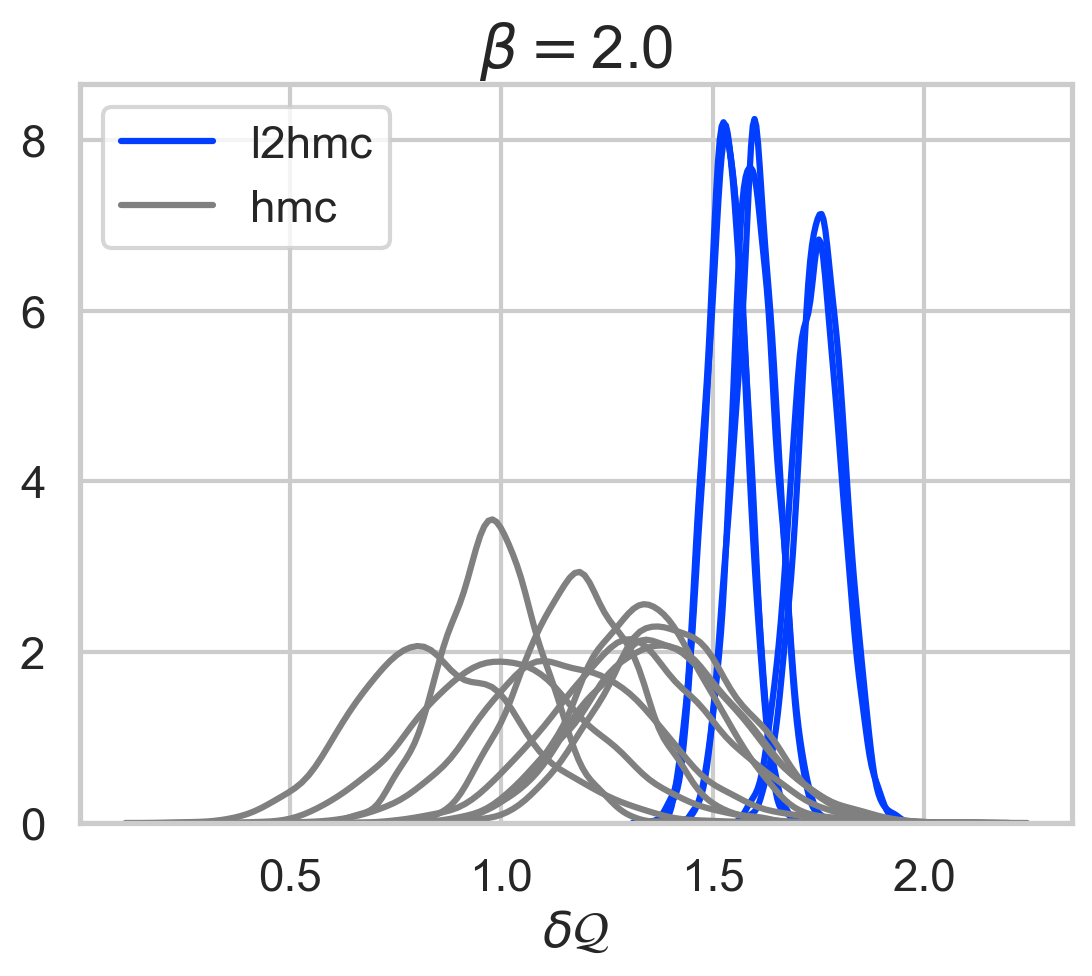

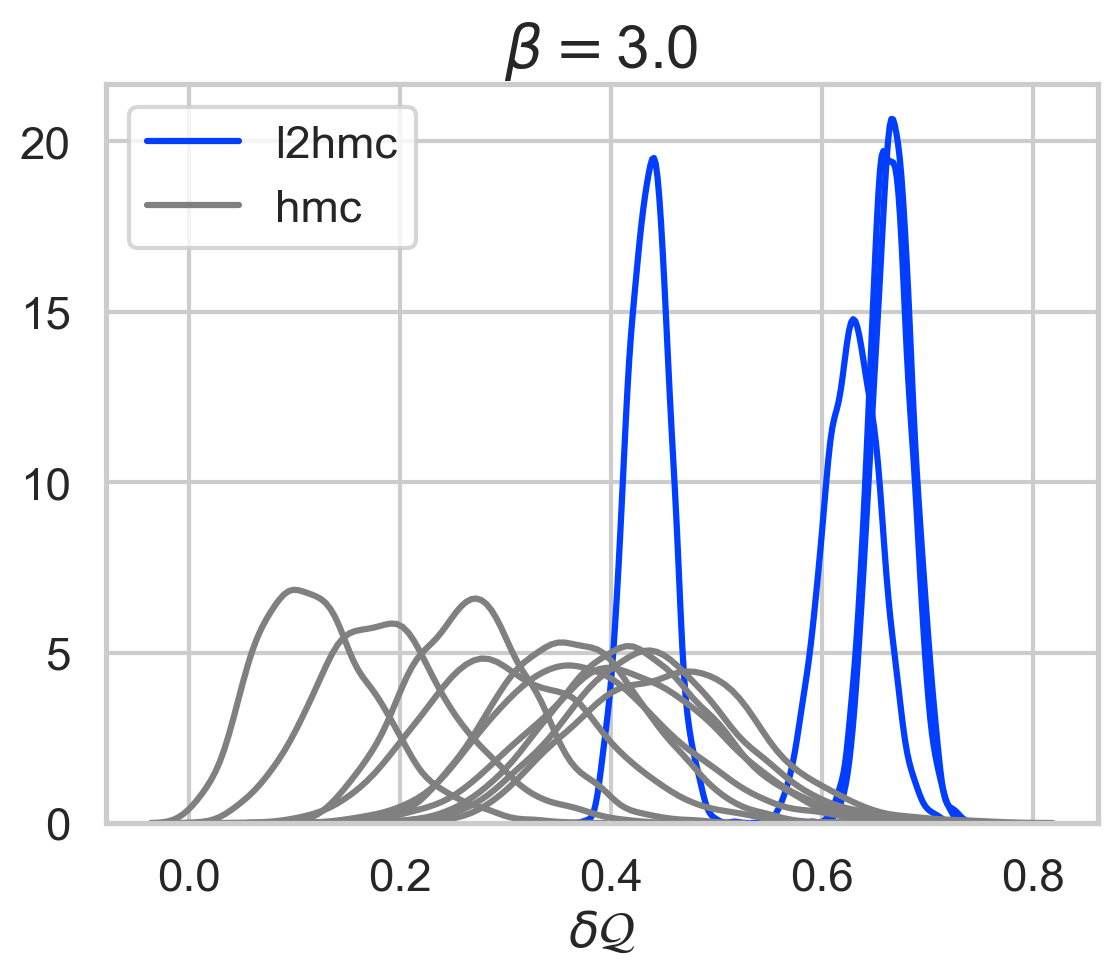

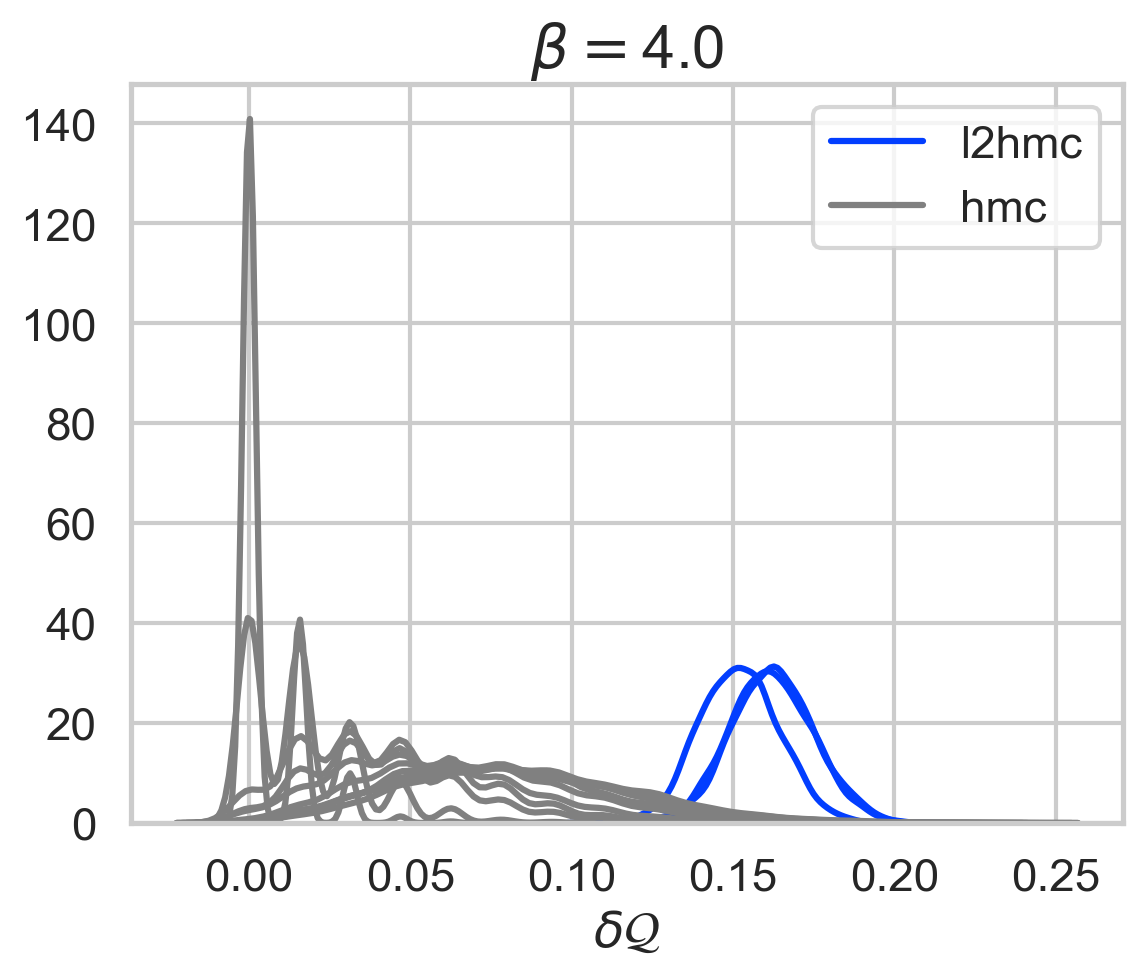

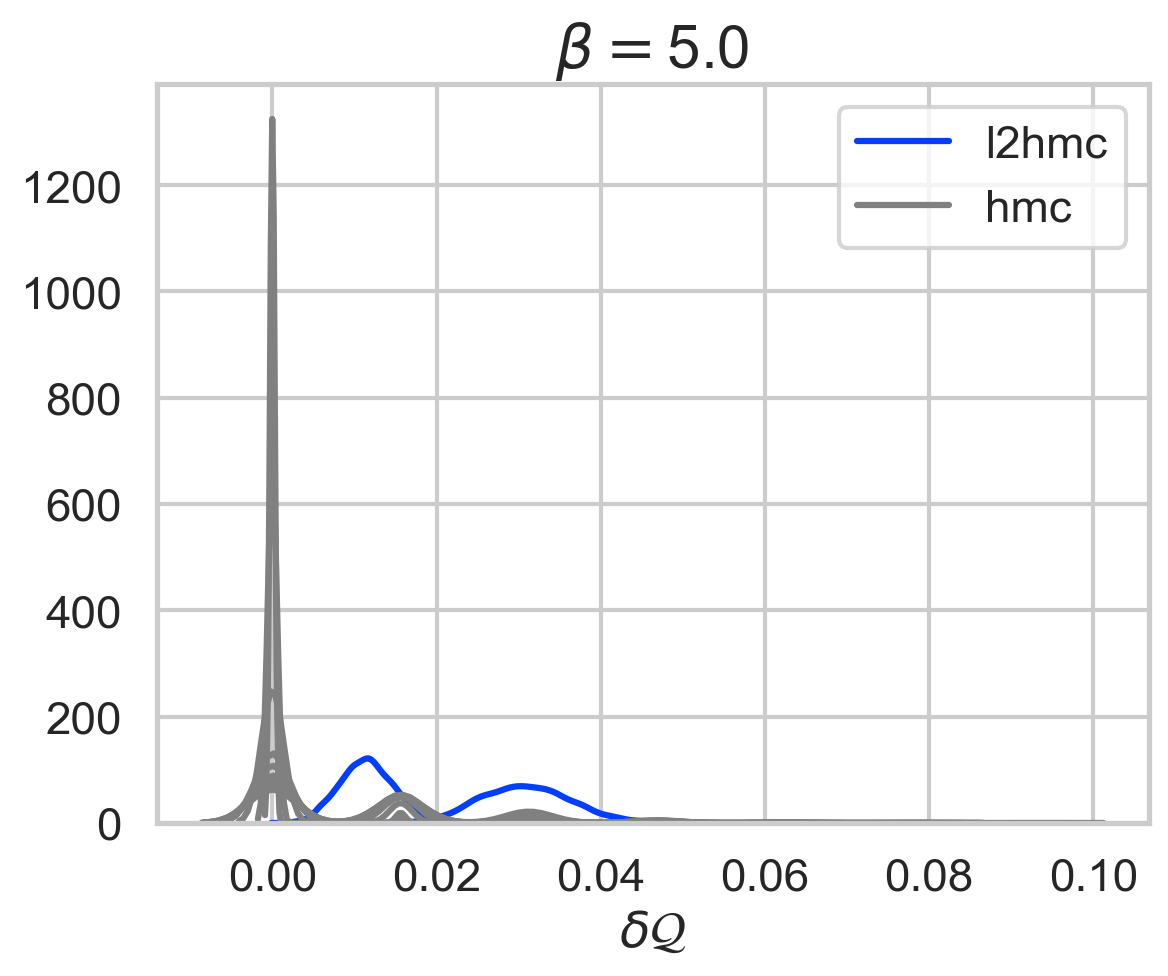

In [133]:
betas_l2hmc = list(dqi_l2hmc.keys())
betas_hmc = list(dqi_hmc.keys())

betas = sorted([x for x in betas_hmc if x in betas_l2hmc])

for beta in betas:
    fig, ax = plt.subplots()
    dqi_l = dqi_l2hmc[beta]
    dqi_h = dqi_hmc[beta]
    data = {}
    data = {'l2hmc': {}, 'hmc': {}}
    kl0 = list(dqi_l.keys())[0]
    for kl, vl in dqi_l.items():
        _, eps = kl
        try:
            data['l2hmc'].update({
                f'{eps:.3g}': vl
            })
        except KeyError:
            data['l2hmc'][f'{eps:.3g}'] = vl
            
        #label_ = 'l2hmc, ' + r"$\varepsilon = $" + f'{eps:.3g}'
        if kl == kl0:
            label = 'l2hmc'
        else:
            label = None
            
        _ = sns.distplot(vl[2500:, :].mean(axis=1), label=label, hist=False, color='C0')
        
    kh0 = list(dqi_h.keys())[0]
    for kh, vh in dqi_h.items():
        _, eps = kh
        try:
            data['hmc'].update({
                f'{eps:.3g}': vh
            })
        except KeyError:
            data['hmc'][f'{eps:.3g}'] = vh
    
        #label_ = 'hmc, ' + r"$\varepsilon = $" + f'{eps:.3g}'
        if kh == kh0:
            label = 'hmc'
        else:
            label = None
            
        _ = sns.distplot(vh[2500:, :].mean(axis=1), label=label, hist=False, color='gray')
        
    _ = ax.legend()
    _ = ax.set_xlabel(r"$\delta \mathcal{Q}$")
    #if beta == 2.0:
    #    _ = ax.set_xlim((0, 2.25))
    #elif beta == 3.0:
    #    _ = ax.set_xlim((0., 1.))
    #elif beta == 4.0:
    #    _ = ax.set_xlim((-0.01, 0.25))
    #elif beta == 5.0:
    #    _ = ax.set_xlim((0, 0.05))
        
    #_ = ax.set_xlim((0, 2.0))
    _ = ax.set_title(r"$\beta = $" + f'{beta}', fontsize='large')

# d3 = {'l2hmc': zl[:, :64], 'hmc': zh}

#fig, ax = plt.subplots()
#for key, val in d3.items():
#    _ = sns.distplot(val.mean(axis=1), label=key, hist=False)
    
_ = ax.legend(loc='best')
#_ = ax.set_xlim((0.5, ax.get_xlim()[1]))
#_ = ax.set_ylim((0, 2))
    

In [145]:
import matplotlib as mpl

In [ ]:
mpl.scale.LogScale(i)

In [84]:
axes.axes_all

## OLDER

<IPython.core.display.Javascript object>


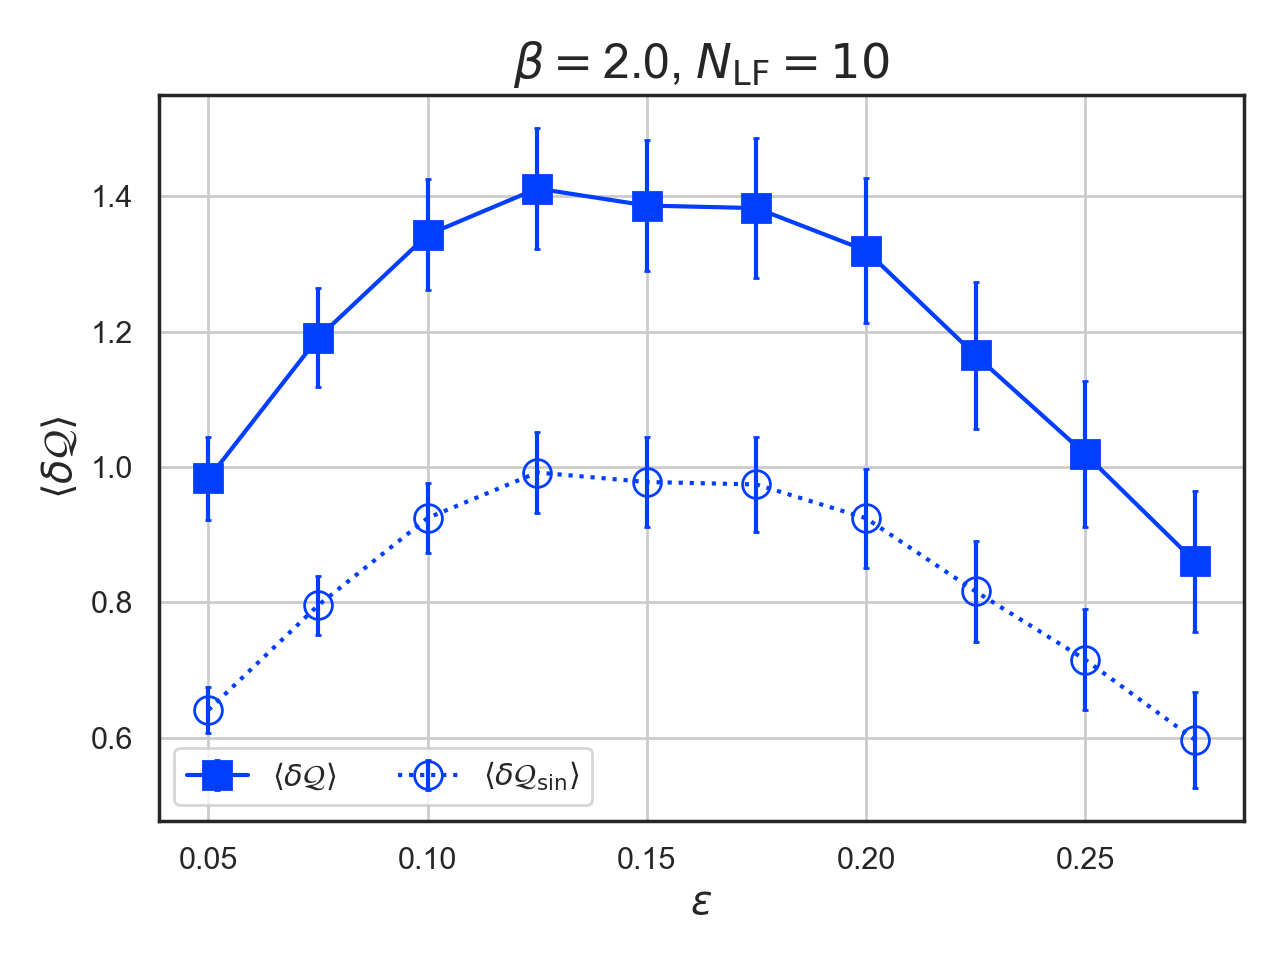

<IPython.core.display.Javascript object>


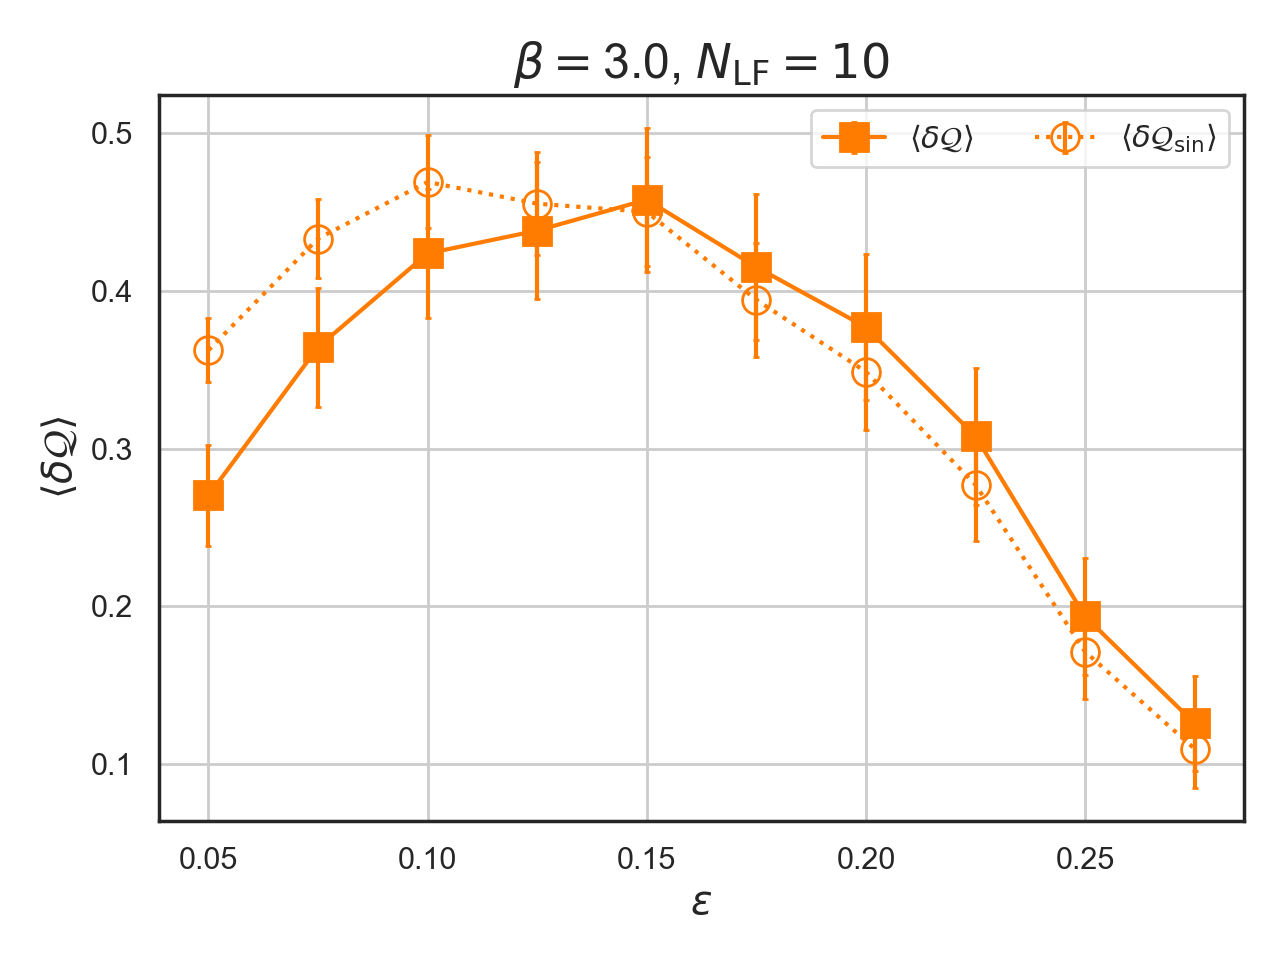

<IPython.core.display.Javascript object>


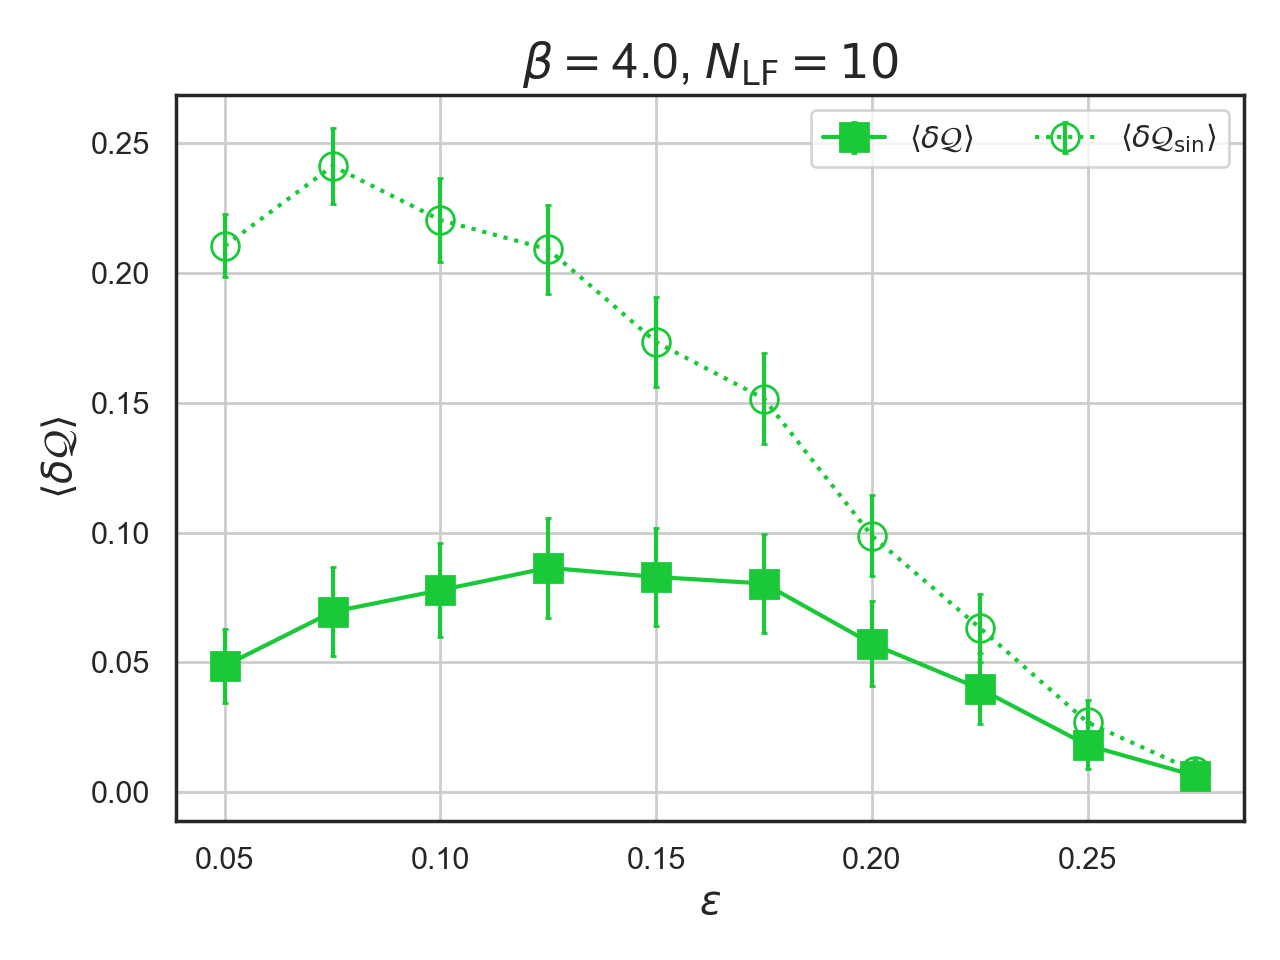

<IPython.core.display.Javascript object>


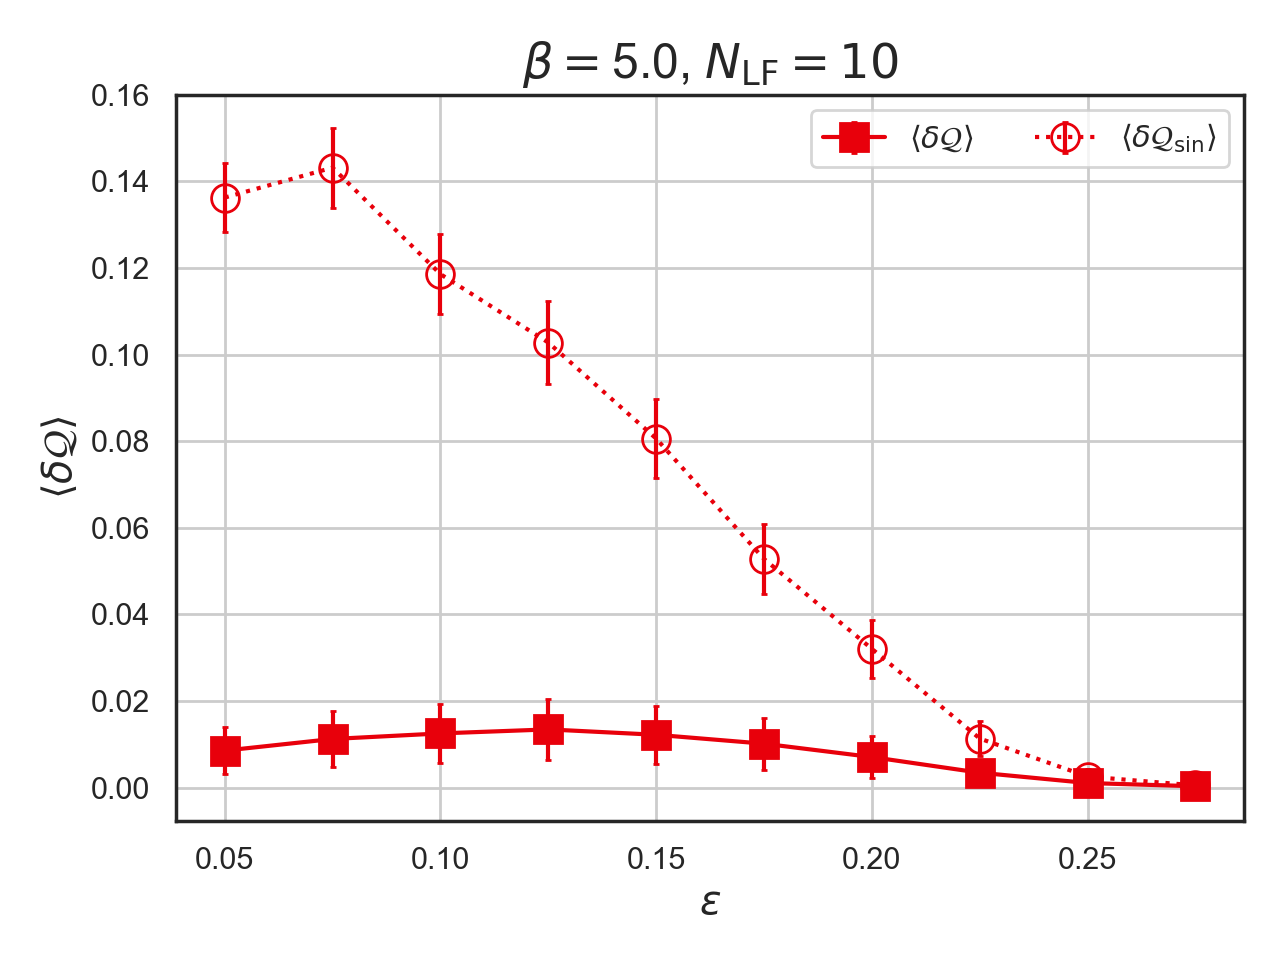

<IPython.core.display.Javascript object>


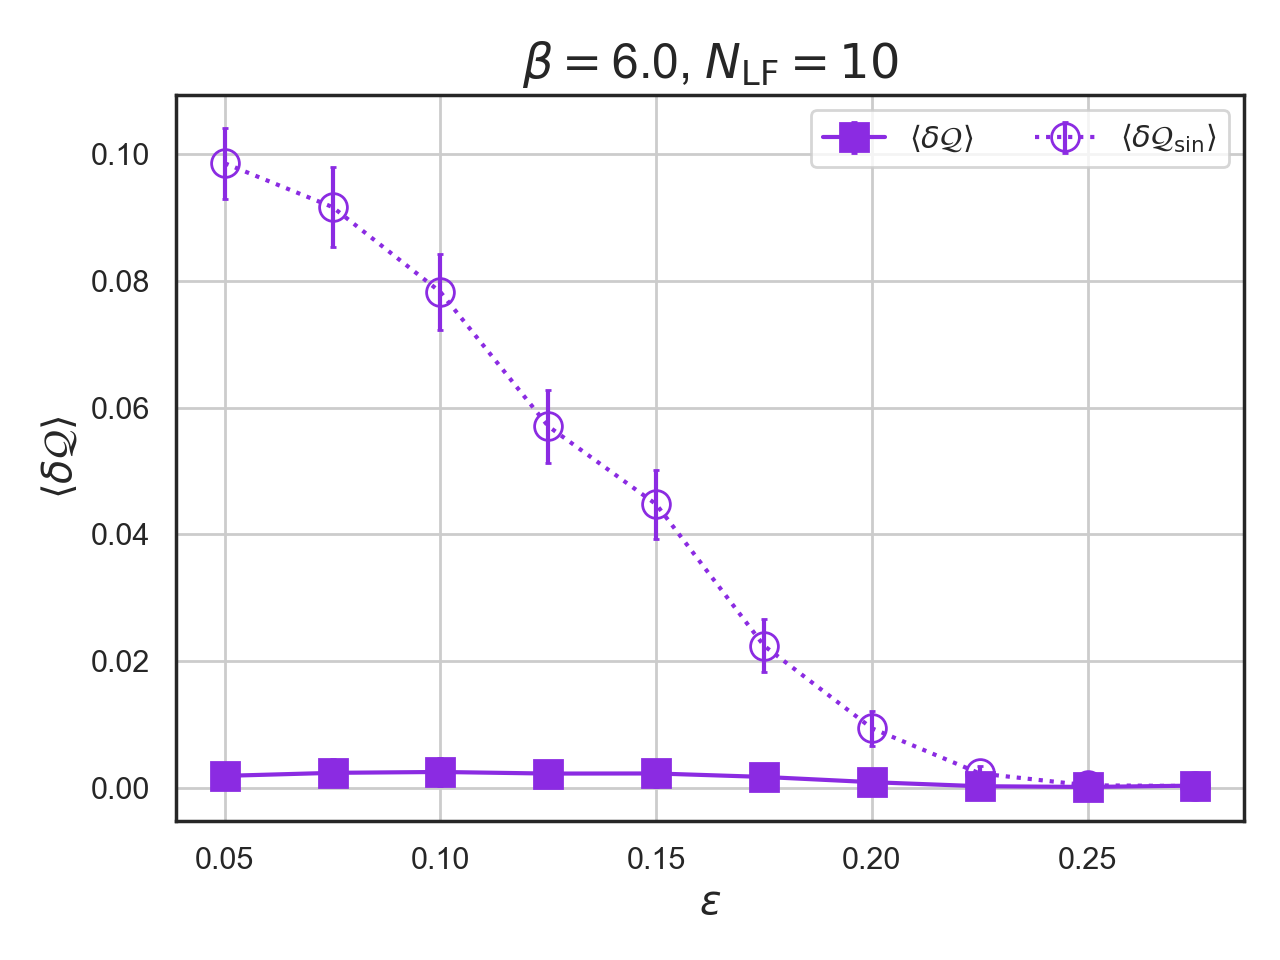

In [16]:
from config import MARKERS, COLORS

#plt.rcParams['savefig.facecolor']='red'
hmc_figs_dir = os.path.join(hmc_log_dir, 'dq_plots_new_2020_10_06')
io.check_else_make_dir(hmc_figs_dir)

dq_int = sorted(dq_int_stats.items(), key=lambda x: x[0])
dq_sin = sorted(dq_sin_stats.items(), key=lambda x: x[0])
#fig, axes = plt.subplots(nrows=len(dq_int_stats.keys()))
#axes = axes.flatten()
for idx, ((kih, vih), (ksh, vsh), k) in enumerate(zip(dq_int, dq_sin)):
    fig, ax = plt.subplots()
    xi = []
    xs = []
    ys = []
    yi = []
    yi_err = []
    ys_err = []
    _vi = sorted(vi.items(), key=lambda x: x[0][1])
    _vs = sorted(vs.items(), key=lambda x: x[0][1])
    #for ki_, vi_ in vi.items():
    for ki_, vi_ in _vi:
        num_steps, eps = ki_
        xi.append(eps)
        yi.append(vi_['avg'])
        yi_err.append(vi_['err'])
        
    for ks_, vs_ in _vs:
        num_steps, eps = ks_
        xs.append(eps)
        ys.append(vs_['avg'])
        ys_err.append(vs_['err'])
        
    _ = ax.errorbar(xi, yi, yi_err, ls='-', marker='s',
                    capsize=1., markersize=10., fillstyle='full',
                    label=r"$\langle\delta\mathcal{Q}\rangle$",
                    color=COLORS[idx])
    _ = ax.errorbar(xs, ys, ys_err, ls=':', marker='o',
                    capsize=1., markersize=10., fillstyle='none',
                    label=r"$\langle\delta\mathcal{Q}_{\sin}\rangle$",
                    color=COLORS[idx])
    
    _ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
    _ = ax.set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", fontsize='large')
    _ = ax.set_title(r"$\beta = $" + f'{ki}, ' + r"$N_{\mathrm{LF}} = 10$", fontsize='x-large')
    _ = ax.legend(loc='best', ncol=2)
    _ = plt.tight_layout()
    _ = plt.grid(True)
    #_ = ax.set_yscale("log", nonposy='clip')
    timestamp = io.get_timestamp()
    out_file = os.path.join(hmc_figs_dir, f'dq_lf10_stats_beta{ki}_{timestamp}'.replace('.', '') + '.png')
    _ = plt.savefig(out_file, dpi=400, bbox_inches='tight') # , facecolor='#1c1c1c')

<IPython.core.display.Javascript object>


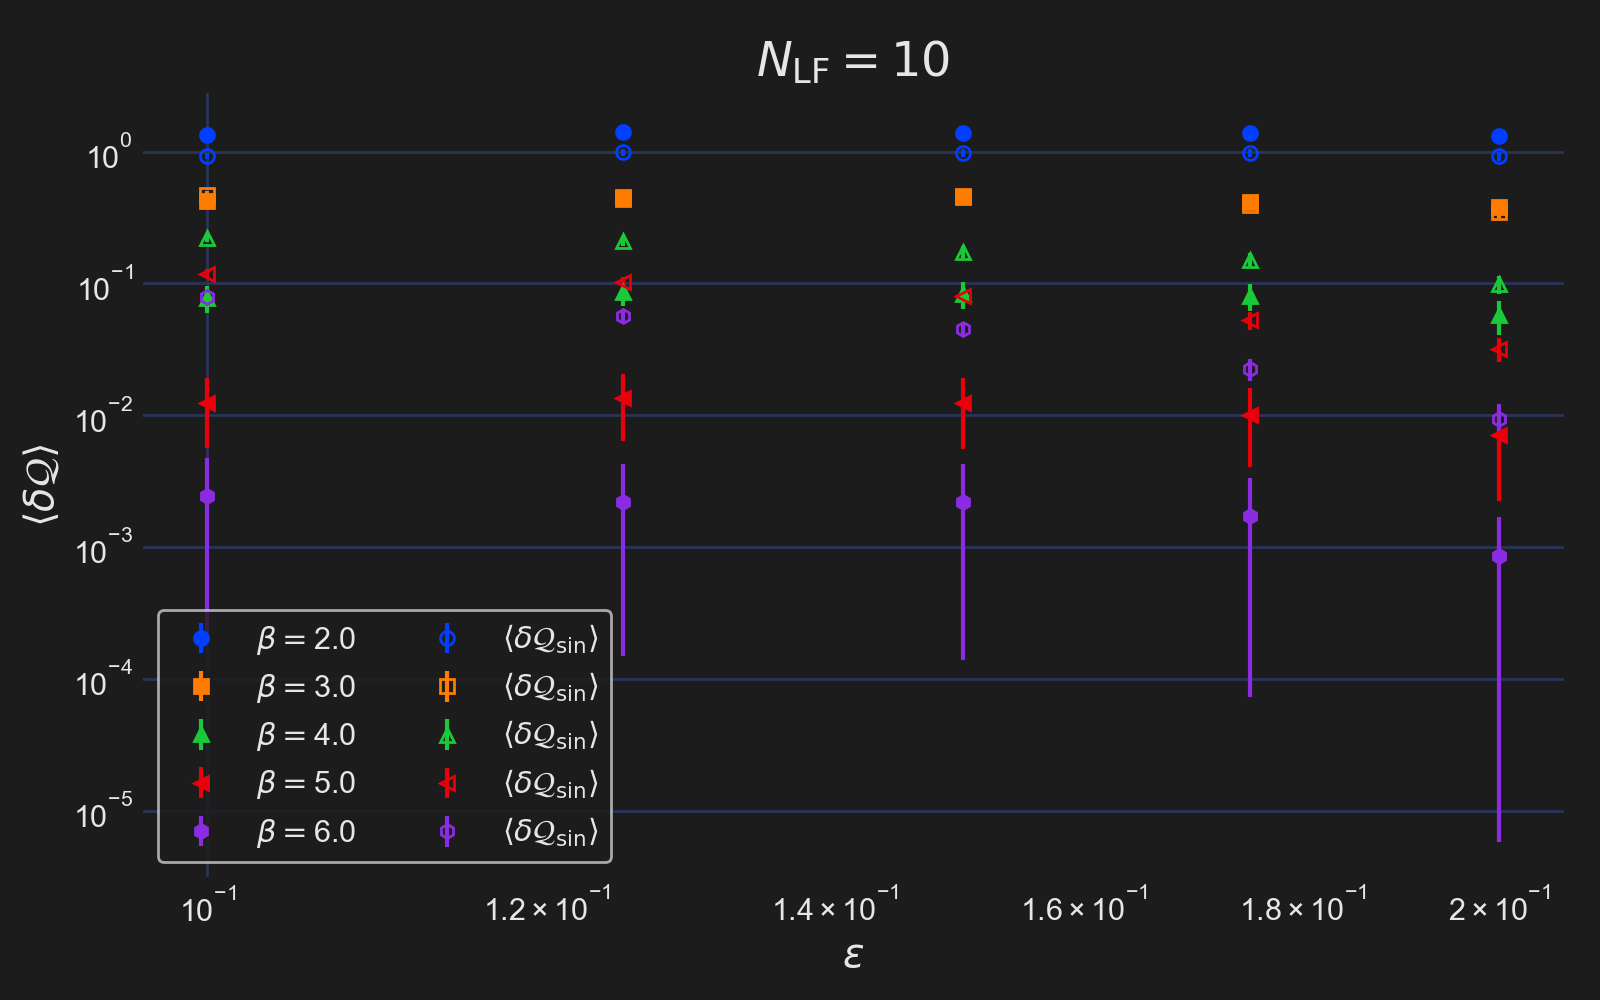

In [48]:
 
    
for idx, (key, val) in enumerate(sorted(dq_int_stats.items())):
fig, ax = plt.subplots(figsize=(8, 5), sharey=True)
    x = []
    y = []
    y_err = []
    for k, v in val.items():
        num_steps, eps = k
        x.append(eps)
        y.append(v['avg'])
        y_err.append(v['err'])
        
    _ = ax.errorbar(x, y, y_err, ls='',
                    label=r'$\beta = $' + f'{key}',
                    markersize=5., fillstyle='full',
                    marker=MARKERS[idx], color=COLORS[idx])
    
    
for idx, (key, val) in enumerate(sorted(dq_sin_stats.items())):
    x = []
    y = []
    y_err = []
    for k, v in val.items():
        num_steps, eps = k
        x.append(eps)
        y.append(v['avg'])
        y_err.append(v['err'])
        
    _ = ax.errorbar(x, y, y_err, ls='',
                    label=r"$\langle\delta\mathcal{Q}_{\sin}\rangle$",
                    #label=r'$\beta = $' + f'{key}',
                    fillstyle='none', markersize=5.,
                    marker=MARKERS[idx], color=COLORS[idx])
    #_ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
    #_ = ax.set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", fontsize='large')
    #_ = ax.set_title(r"$N_{\mathrm{LF}} = 10$")
    #_ = axes[1].legend(loc='best')

    #ax.set_title(r"$\beta = $" + f'{key}')
        
_ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
_ = ax.set_ylabel(r"$\langle\delta\mathcal{Q}\rangle$", fontsize='large')
_ = ax.set_title(r"$N_{\mathrm{LF}} = 10$", fontsize='x-large')
_ = ax.legend(loc='best', ncol=2)
_ = plt.tight_layout()
_ = ax.set_yscale("log", nonposy='clip')
timestamp = io.get_timestamp()
out_file = os.path.join(hmc_figs_dir, f'dq_lf10_stats_{timestamp}.png')
_ = plt.savefig(out_file, dpi=400, bbox_inches='tight', facecolor='#1c1c1c')

<IPython.core.display.Javascript object>


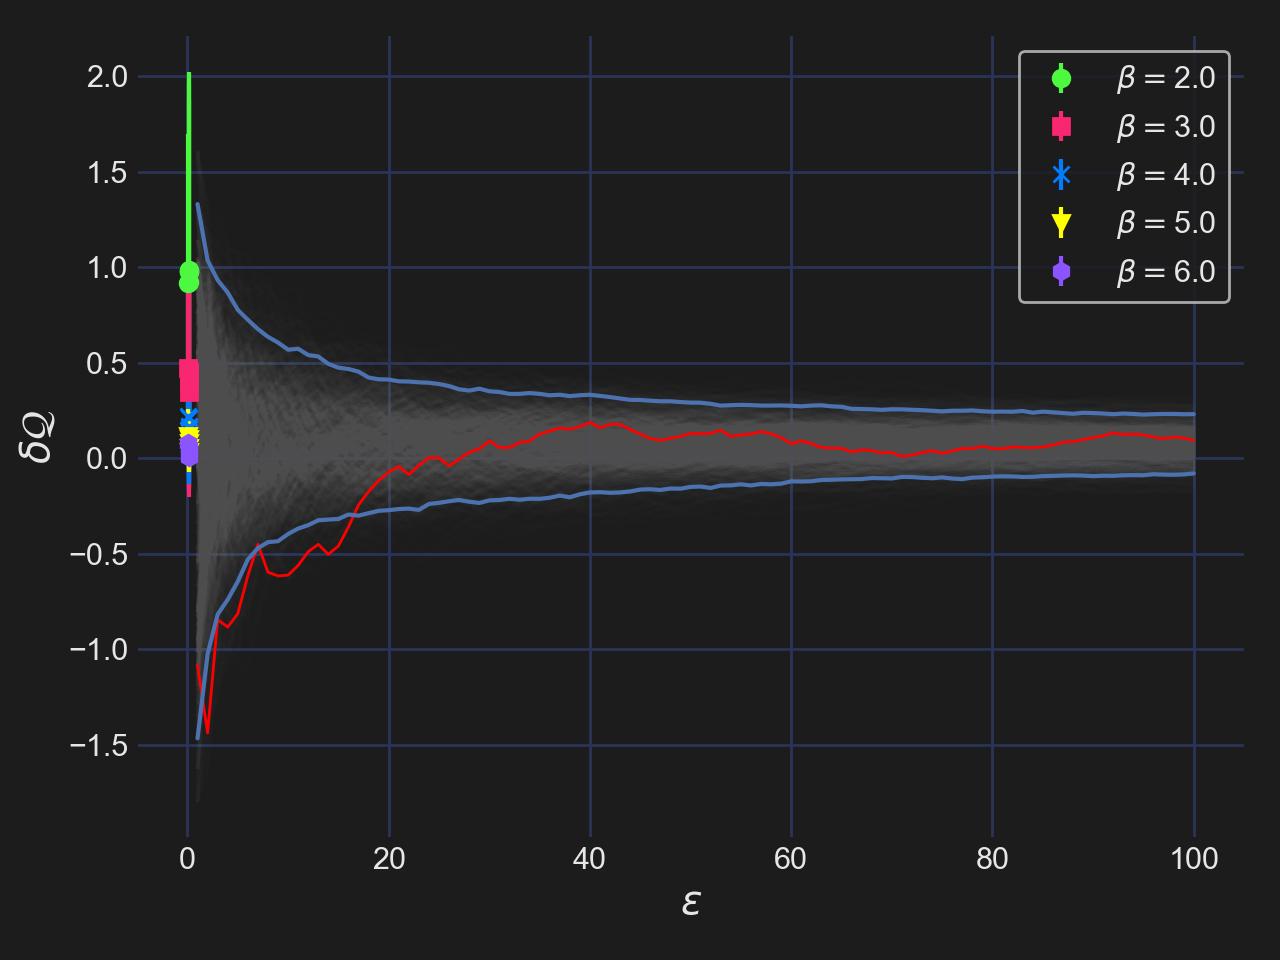

In [146]:
from config import MARKERS

dq_int = {}
#fig, axes = plt.subplots(nrows=len(dq_int_stats.keys()))
#axes = axes.flatten()
fig, ax = plt.subplots()
for idx, (key, val) in enumerate(sorted(dq_sin_stats.items())):
    x = []
    y = []
    y_err = []
    for k, v in val.items():
        num_steps, eps = k
        x.append(eps)
        y.append(v['avg'])
        y_err.append(v['std'])
        
    #axes[idx].errorbar(x, y, y_err)
    _ = ax.errorbar(x, y, y_err, ls='', marker=MARKERS[idx], label=r'$\beta = $' + f'{key}')
    _ = ax.set_xlabel(r"$\varepsilon$", fontsize='large')
    _ = ax.set_ylabel(r"$\delta\mathcal{Q}$", fontsize='large')
    _ = plt.legend(loc='best')
    #ax.set_title(r"$\beta = $" + f'{key}')
    _ = plt.tight_layout()
        

In [94]:
io.print_dict(dq_int_stats, name='dq_int_stats')
io.print_dict(dq_sin_stats, name='dq_sin_stats')

dq_int_stats:
------------
  4.0:
  ---
    (10, 0.175):
    -----------
      avg: 0.07933614403009415
      std: 0.28694701194763184
      min: 0
      max: 3
    (10, 0.125):
    -----------
      avg: 0.08561745285987854
      std: 0.29094022512435913
      min: 0
      max: 3
    (10, 0.1):
    ---------
      avg: 0.07720345258712769
      std: 0.27463144063949585
      min: 0
      max: 3
    (10, 0.2):
    ---------
      avg: 0.05437120795249939
      std: 0.24383173882961273
      min: 0
      max: 3
    (10, 0.16):
    ----------
      avg: 0.07912912219762802
      std: 0.28512659668922424
      min: 0
      max: 4
    (10, 0.15):
    ----------
      avg: 0.0805392935872078
      std: 0.28575170040130615
      min: 0
      max: 3
  3.0:
  ---
    (10, 0.15):
    ----------
      avg: 0.4561446011066437
      std: 0.6807785034179688
      min: 0
      max: 6
    (10, 0.2):
    ---------
      avg: 0.3745351731777191
      std: 0.6879435777664185
      min: 0
      max: 7
  

In [80]:
%debug

> /Users/saforem2/l2hmc-qcd/l2hmc-qcd/utils/file_io.py(128)print_dict()
    126         sep_str = indent_str + len(name) * '-'
    127         log(sep_str, **kwargs)
--> 128     for key, val in d.items():
    129         if isinstance(d, (AttrDict, dict)):
    130             print_dict(val, indent=indent+2, name=str(key), **kwargs)

ipdb> x = d
ipdb> x.items()
*** AttributeError: 'tuple' object has no attribute 'items'
ipdb> x
(0.079336144, 0.286947)
ipdb> x
(0.079336144, 0.286947)
ipdb> quit


In [77]:
dq_sin_stats

{4.0: {(10, 0.175): (0.1521019, 0.26443395),
  (10, 0.125): (0.20872988, 0.2563737),
  (10, 0.1): (0.220758, 0.24189393),
  (10, 0.2): (0.09623339, 0.23055416),
  (10, 0.16): (0.15968636, 0.26125705),
  (10, 0.15): (0.170749, 0.25906423)},
 3.0: {(10, 0.15): (0.4495216, 0.5215852),
  (10, 0.2): (0.34716162, 0.54797816),
  (10, 0.175): (0.38995403, 0.539692),
  (10, 0.1): (0.47058344, 0.43851098),
  (10, 0.125): (0.4528759, 0.48418865)},
 5.0: {(10, 0.1): (0.11855335, 0.13835438),
  (10, 0.175): (0.05252867, 0.12167294),
  (10, 0.2): (0.032098874, 0.101736665),
  (10, 0.125): (0.10199289, 0.14115505),
  (10, 0.15): (0.08075489, 0.13741735)},
 6.0: {(10, 0.15): (0.04474526, 0.08106277),
  (10, 0.125): (0.057241946, 0.08608513),
  (10, 0.175): (0.022115912, 0.063013814),
  (10, 0.1): (0.07813317, 0.09022369),
  (10, 0.2): (0.008726718, 0.041257907)},
 2.0: {(10, 0.15): (0.9800828, 0.97632915),
  (10, 0.175): (0.9737217, 1.0451647),
  (10, 0.125): (0.986235, 0.88797414),
  (10, 0.1): (0.91

In [66]:
from utils.data_utils import therm_arr

dq_int = {}
for key, val in dq_int_dict.items():
    beta = key
    for k, v in val.items():
        data = therm_arr(v, ret_steps=False)
        try:
            dq_int[key].update({
                k: (np.mean(data), np.std(data))
            })
        except KeyError:
            dq_int[key] = {
                k: (np.mean(data), np.std(data))
            }
    

{4.0: {(10, 0.175): (0.079336144, 0.286947),
  (10, 0.125): (0.08561745, 0.29094023),
  (10, 0.1): (0.07720345, 0.27463144),
  (10, 0.2): (0.054371208, 0.24383174),
  (10, 0.16): (0.07912912, 0.2851266),
  (10, 0.15): (0.08053929, 0.2857517)},
 3.0: {(10, 0.15): (0.4561446, 0.6807785),
  (10, 0.2): (0.37453517, 0.6879436),
  (10, 0.175): (0.4106016, 0.6855541),
  (10, 0.1): (0.4241798, 0.61346316),
  (10, 0.125): (0.43722662, 0.6457952)},
 5.0: {(10, 0.1): (0.011617525, 0.10748271),
  (10, 0.175): (0.008898574, 0.095519304),
  (10, 0.2): (0.0063360166, 0.08042181),
  (10, 0.125): (0.012418249, 0.11172512),
  (10, 0.15): (0.011597873, 0.10837155)},
 6.0: {(10, 0.15): (0.0014181541, 0.038042184),
  (10, 0.125): (0.0018049281, 0.042718466),
  (10, 0.175): (0.00091415126, 0.030859185),
  (10, 0.1): (0.0018011117, 0.042489406),
  (10, 0.2): (0.00043362874, 0.021005195)},
 2.0: {(10, 0.15): (1.3870312, 1.4414281),
  (10, 0.175): (1.3827344, 1.5342593),
  (10, 0.125): (1.3982812, 1.3342794),


In [60]:
k = list(dq_int_dict[2.0].keys())[0]

In [61]:
k

(10, 0.15)

In [63]:
dq_int_dict[2.][k].shape

(5000, 64)

In [44]:
dq_int_dict.keys()

dict_keys([4.0])

In [15]:
hdir = hmc_dirs[0]
run_data_files = sorted(hdir.glob('**/*.z'))

In [17]:
hdirs = [x for x in hdir.iterdir() if x.is_dir()]
hdirs

[PosixPath('/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps01_bi2_bf2-2020-10-05-171043/beta2-2020-10-05-1710')]

In [19]:
zfiles = sorted(hdirs[0].glob('**/*.z'))
zfiles

[]

In [2]:
base_dir = os.path.abspath('/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/')
hmc_dirs = [
    os.path.join(base_dir, i) for i in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, i))
]

def get_run_data(hmc_dir, fname):
    tmp_dir = os.listdir(hmc_dir)[0]
    run_dir = os.path.join(hmc_dir, tmp_dir) 
    run_data_dir = os.path.j

['/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps01_bi2_bf2-2020-10-05-171043',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps0175_bi4_bf4-2020-10-05-131208',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps015_bi3_bf3-2020-10-05-125013',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps02_bi3_bf3-2020-10-05-125734',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps01_bi5_bf5-2020-10-05-131908',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_bi3_bf3-2020-10-05-120411',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_bi4_bf4-2020-10-05-121415',
 '/Users/saforem2/l2hmc-qcd/logs/GaugeModel_logs/hmc_logs/2020_10/HMC_DEBUG_L16_b64_lf10_qw001_eps015_bi6_